# Table Of Content:
* Preliminaries
    * [Structure of the lab](#structure)
    * [Objective of the lab](#objective)
    * [How to work for the lab?](#howto)
    * [Setting up the scene](#scene)
* [Part 1: Geometry](#part1)
    * [I. Computing the target configurations (Inverse Geometry)](#IG)
    * [II. Motion planning](#motion_planning)
* [Part 2: Dynamics](#part2)
    * [I. From a path to a trajectory](#TO)
    * [II. Implementing a control law](#control)




# Structure of the lab:  <a class="anchor" id="structure"></a>
The lab is divided into separate python files, each designed for you to address a sub-problem atomically. These instructions will indicate where you should implement each task. At the end of each file, in the 'main' 
section you can locally test your functions. It is important that you **do not modify the names and signatures** of the methods provided: When marking the lab, I will in first instance run code that will use these functions to evaluate quantitatively the methods you proposed. 

# Objective of the lab <a class="anchor" id="objective"></a>
Use both effectors of the nextage robot to grab a box and bring it to a target location.
You will first plan a valid motion that brings the robot to a grasping configuration, then moves the box to 
a desired location while avoiding collisions. For this you will use a combination of motion planning and numerical optimisation.

Once this motion plan will be computed, you will test it in a dynamics simulator using a control method of your choice.
This will be the objective of part 2 of the lab.

In the optional part 3 of the lab (for exceptional marks), you will be asked to self-propose a more complex task to achieve, which will require you to implement additional features to your framework. 

# How to work for the lab? <a class="anchor" id="howto"></a>
You have been used to notebooks for the tutorials, and these instructions also take the form of a notebook. To implement this lab I personally chose to work directly with a python IDE and I recommend to do the same. I worked with spyder but any python IDE might work as well. You can decide to work using notebooks if you prefer, this is not a problem, as long as your final deliverables meet the requirement specification.

**In any case, keep your code in a versioning system**. You are free to use github gitlab or whatever service you are more comfortable working with. The easiest way to work is to "fork" the lab repository from github into your own account and adding this new repository as a remote server.



## Code production
You are free to reuse code from the tutorials or any other source as long as you explicitely **cite its origin both in the code and in your report**. You are free to use any method from the pinocchio API and to create as many methods as you would like. **If you want to use non-native python libraries**, we must discuss this. Remember that I will have to run your code to assess your lab!


## I don't like the approach you have proposed to solve the problem. Can I do my own thing?
Yes... and no. First of all, I would suggest that you discuss this with the TAs / myself before going for it. Secondly, you will see in the submission requirements that I only need some methods to be implemented for me to assess quantitatively your work. I consider that if all of these methods are implemented you followed the instructions. The report will then give you a chance to justify your approach. This should give you a lot of freedom. In particular at step 2 I propose to use motion planning to compute a reference path for the robot. If you choose a different approach it does not matter to me as long as we discussed it before and that it is not hard-coded somehow. 

# Setting up the scene <a class="anchor" id="scene"></a>

To ensure efficient use of resources and to prevent the unintentional creation of multiple Meshcat server instances, I recommend initializing the server through the command line. Here's how you can do it:

- Open a terminal. If you're on Ubuntu, you can quickly do this by pressing `ctrl + alt + t`.
- Enter the following command and press `Enter`:
   ```
   meshcat-server 
   ```
- Upon running the command, you'll receive an output that includes the "zmq_url". This is the address to which you will connect.

**Tip**: You can run terminal commands directly from the Jupyter Notebook by prefixing them with `!`. However, for the purpose of this lab, I recommend initializing the Meshcat server directly from the terminal.


In [1]:
!meshcat-server

Port: 6000 in use, trying another...
Port: 7000 in use, trying another...
zmq_url=tcp://127.0.0.1:6001
web_url=http://127.0.0.1:7001/static/
^C


A helper function has been implemented to automatically connect to meshcat server, load the scene and the robot, and setup the collision handler in pinocchio for you.

In [1]:
from tools import setupwithmeshcat
robot, cube, viz = setupwithmeshcat(url="tcp://127.0.0.1:6000")

Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [2]:
from tools import *

```setupwithmeshcat``` takes an optional parameter corresponding to the url (zmq_url) of the meshcat server (given as a string). If no url is provided, it uses the variable ```MESHCAT_URL``` defined in config.py . If for some reason the default url does not match the one you are using, you can either provide this url to ```setupwithmeshcat``` or simply replace the value of ```MESHCAT_URL```

In [3]:
from config import MESHCAT_URL
print(MESHCAT_URL)

tcp://127.0.0.1:6000


In [4]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

## Description of the environment.
The environment is composed of a fixed table and an obstacle, as well as a cube, which you are supposed to bring 
to the green target.

## Description of the robot. 
The robot you will use for the lab is the Nextage robot from Kawada industries.
You can use both pinocchio and the [URDF files](https://github.com/ediaro23/lab/blob/9a2b0c74b4ba1702da8f86fc1fa845e513ab4cfd/models/nextagea_description/urdf/NextageaOpen.urdf) to check the dimension of the robot configuration space.
The configuration velocity space has the same dimension as Nextage is only composed of revolute joints.

In [5]:
print(robot.model)

Nb joints = 16 (nq=15,nv=15)
  Joint 0 universe: parent=0
  Joint 1 CHEST_JOINT0: parent=0
  Joint 2 HEAD_JOINT0: parent=1
  Joint 3 HEAD_JOINT1: parent=2
  Joint 4 LARM_JOINT0: parent=1
  Joint 5 LARM_JOINT1: parent=4
  Joint 6 LARM_JOINT2: parent=5
  Joint 7 LARM_JOINT3: parent=6
  Joint 8 LARM_JOINT4: parent=7
  Joint 9 LARM_JOINT5: parent=8
  Joint 10 RARM_JOINT0: parent=1
  Joint 11 RARM_JOINT1: parent=10
  Joint 12 RARM_JOINT2: parent=11
  Joint 13 RARM_JOINT3: parent=12
  Joint 14 RARM_JOINT4: parent=13
  Joint 15 RARM_JOINT5: parent=14



In [50]:
robot.q0.shape

(15,)

In [81]:
q_test = np.array([0,0,0,0,180,90,0,-90,-90,0,0,0,0,0,0])
updatevisuals(viz, robot, cube, q_test)

In [54]:
updatevisuals(viz, robot, cube, q_test)

You can also verify that in its default configuration the robot is in collision (with the table)

In [6]:
from tools import collision
collision(robot, robot.q0)

True

# Configuration and helper functions  <a class="anchor" id="config"></a>

I have modified the URDF files to add frames that are relevant for the tasks you need to accomplish.
On the robot, I have created fixed joints attached to the tip of each effectors, called ```LARM_EFF``` and ```RARM_EFF```. Note that because they are fixed joints, they do not appear in the robot model and do not change the dimension of the configuration space. These names are defined for you in the config.py file as well. 

In [82]:
from config import LEFT_HAND, RIGHT_HAND

print ("Left hand joint name: ", LEFT_HAND)


import pinocchio as pin
q = robot.q0.copy()

#update the frame positions in robot.data given q
pin.framesForwardKinematics(robot.model,robot.data,q_test)

#now let's print the placement attached to the right hand
print ("Left hand joint placement: ")
pin.computeJointJacobians(robot.model,robot.data,q_test)
frameid = robot.model.getFrameId(LEFT_HAND)
oMframe = robot.data.oMf[frameid] 
print(oMframe)



Left hand joint name:  LARM_EFF
Left hand joint placement: 
  R =
-0.535022 -0.268152 -0.801153
 -0.44807  0.893998         0
 0.716229  0.358973  -0.59846
  p =  0.68863 0.134289  1.56092



In [8]:
oMframe.translation

array([0.452, 0.28 , 0.851])

Likewise the cube urdf (models/cubes/cube_small.urdf) also contains helpers joint that set a target location for the effectors. They are called ```LEFT_HOOK``` and ```RIGHT_HOOK``` in config.py.

I added meshcat helper functions that will allow you to display the associated frames if you wish.

In [9]:
from config import LEFT_HOOK, RIGHT_HOOK, CUBE_PLACEMENT, CUBE_PLACEMENT_TARGET

from tools import getcubeplacement, setcubeplacement
from setup_meshcat import updatevisuals




#the cube position is updated using the following function:
setcubeplacement(robot, cube, CUBE_PLACEMENT_TARGET)
#to update the frames for both the robot and the cube you can call
updatevisuals(viz, robot, cube, q)

#We can access the current cube position using
oMcube  = getcubeplacement(cube) #origin of the cube
oMcubeL = getcubeplacement(cube, LEFT_HOOK) #placement of the left hand hook
oMcubeR = getcubeplacement(cube, RIGHT_HOOK) #placement of the right hand hook


In [10]:
oMcubeL

  R =
1 0 0
0 1 0
0 0 1
  p =  0.4 0.15 0.93

In [11]:
oMcubeR

  R =
  -0.999999  0.00159265           0
-0.00159265   -0.999999           0
         -0           0           1
  p =  0.4 0.05 0.93

In [12]:
oMcubeR.translation - oMcubeL.translation

array([ 0. , -0.1,  0. ])

In [13]:
def distance(obj1, obj2):
    # Translation difference
    translation_diff = obj1.translation - obj2.translation

    # Rotation difference (using log map for SO3)
    rotation_diff_vector = pin.log(obj1.rotation.transpose() * obj2.rotation)

    # Combine translation and rotation differences into a single vector
    distance_vector = np.concatenate([translation_diff, rotation_diff_vector])

    # Euclidean distance
    dist = np.linalg.norm(distance_vector)
    
    return dist

In [14]:
def cost(q):
    pin.framesForwardKinematics(robot.model,robot.data,q)
    pin.computeJointJacobians(robot.model,robot.data,q)
    
    # Left Side
    frameidL = robot.model.getFrameId(LEFT_HAND)
    oMframeL = robot.data.oMf[frameidL]
    oMcubeL = getcubeplacement(cube, LEFT_HOOK)
    
    # Right Side
    frameidR = robot.model.getFrameId(RIGHT_HAND)
    oMframeR = robot.data.oMf[frameidR]
    oMcubeR = getcubeplacement(cube, RIGHT_HOOK)
    
    return distance(oMframeL, oMcubeL) + distance(oMframeR, oMcubeR)

In [15]:
def penalty(q):
    return cost(q) + 100 * collision(robot, q)**2 + 100 * jointlimitsviolated(robot, q)**2

In [16]:
from scipy.optimize import fmin_bfgs,fmin_slsqp
import numpy as np
import time

In [17]:
def computeqgrasppose(robot, qcurrent, cube, cubetarget, viz=None):
    '''Return a collision free configuration grasping a cube at a specific location and a success flag'''
    setcubeplacement(robot, cube, cubetarget)
    
    qopt_bfgs = fmin_slsqp(penalty, q, callback=lambda q: updatevisuals(viz, robot, cube, q), iter=1000)
    
    return qopt_bfgs, True

In [18]:
q_start, _ = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT, viz)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.00000715006719
            Iterations: 32
            Function evaluations: 558
            Gradient evaluations: 32


In [19]:
q_end, _ = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT_TARGET, viz)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.00003172895975
            Iterations: 33
            Function evaluations: 569
            Gradient evaluations: 33


In [20]:
q = pin.neutral(robot.model)
updatevisuals(viz, robot, cube, q)

In [21]:
# Final Working

def cost(q):
    oMcube  = getcubeplacement(cube) #origin of the cube
    oMcubeL = getcubeplacement(cube, LEFT_HOOK) #placement of the left hand hook
    oMcubeR = getcubeplacement(cube, RIGHT_HOOK) #placement of the right hand hook
    
    pin.framesForwardKinematics(robot.model,robot.data,q)   
    pin.computeJointJacobians(robot.model,robot.data,q)
    
    frameidL = robot.model.getFrameId(LEFT_HAND)
    oMframeL = robot.data.oMf[frameidL]
    frameidR = robot.model.getFrameId(RIGHT_HAND)
    oMframeR = robot.data.oMf[frameidR]
    
    L_hand_tran = oMframeL.translation - oMcubeL.translation
    R_hand_tran = oMframeR.translation - oMcubeR.translation
    L_hand_rot = oMframeL.rotation - oMcubeL.rotation
    R_hand_rot = oMframeR.rotation - oMcubeR.rotation
    
    #hand_tran = oMframeL.translation
    #hook_tran = oMcubeL.translation
    #hand_rot = oMframeL.rotation
    #hook_rot = oMcubeL.rotation
    L_hand_difference = np.linalg.norm(L_hand_tran)**2 + np.linalg.norm(L_hand_rot)**2
    R_hand_difference = np.linalg.norm(R_hand_tran)**2 + np.linalg.norm(R_hand_rot)**2
    
    return R_hand_difference + L_hand_difference + 100 * collision(robot, q)**2 + 100 * jointlimitsviolated(robot, q)**2

def callback(q):
    updatevisuals(viz, robot, cube, q)
    time.sleep(.1)


def computeqgrasppose(robot, qcurrent, cube, cubetarget, viz=None):
    '''Return a collision free configuration grasping a cube at a specific location and a success flag'''
    setcubeplacement(robot, cube, cubetarget)

    q = robot.q0.copy() 
    qopt_bfgs = fmin_slsqp(cost,q,callback=callback)
    print('\n *** Optimal configuration from BFGS = %s \n\n\n\n' % qopt_bfgs)

    return qopt_bfgs, False

In [85]:
q_start, _ = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT, viz)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.013197090195241e-07
            Iterations: 28
            Function evaluations: 454
            Gradient evaluations: 28

 *** Optimal configuration from BFGS = [-3.42545240e-01 -1.55762969e-16 -1.80150788e-16 -8.98293311e-01
 -9.28462082e-03 -2.28475677e-01  1.10587655e-04  2.37682198e-01
 -3.29967824e-01 -2.15240728e-01 -2.82051442e-01  7.32629136e-02
  4.43019140e-05  2.08773063e-01  2.13015551e+00] 






In [22]:
q_end, _ = computeqgrasppose(robot, robot.q0, cube, CUBE_PLACEMENT_TARGET, viz)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 100.00000063464859
            Iterations: 21
            Function evaluations: 342
            Gradient evaluations: 21

 *** Optimal configuration from BFGS = [ 1.11124347e-01  1.48750232e-16  1.04156990e-16 -1.17242837e-01
  1.39651710e-02 -2.52268184e-01 -2.46690969e-05  2.38378833e-01
 -1.56455988e+00  5.19760868e-01  1.28786389e-01 -3.61552492e-01
 -2.18442109e-05  2.32869940e-01  9.41576392e-01] 






In [27]:
# Final For Path Planning

def cost(q):
    oMcube  = getcubeplacement(cube) #origin of the cube
    oMcubeL = getcubeplacement(cube, LEFT_HOOK) #placement of the left hand hook
    oMcubeR = getcubeplacement(cube, RIGHT_HOOK) #placement of the right hand hook
    
    pin.framesForwardKinematics(robot.model,robot.data,q)   
    pin.computeJointJacobians(robot.model,robot.data,q)
    
    frameidL = robot.model.getFrameId(LEFT_HAND)
    oMframeL = robot.data.oMf[frameidL]
    frameidR = robot.model.getFrameId(RIGHT_HAND)
    oMframeR = robot.data.oMf[frameidR]
    
    L_hand_tran = oMframeL.translation - oMcubeL.translation
    R_hand_tran = oMframeR.translation - oMcubeR.translation
    L_hand_rot = oMframeL.rotation - oMcubeL.rotation
    R_hand_rot = oMframeR.rotation - oMcubeR.rotation
    
    #hand_tran = oMframeL.translation
    #hook_tran = oMcubeL.translation
    #hand_rot = oMframeL.rotation
    #hook_rot = oMcubeL.rotation
    L_hand_difference = np.linalg.norm(L_hand_tran)**2 + np.linalg.norm(L_hand_rot)**2
    R_hand_difference = np.linalg.norm(R_hand_tran)**2 + np.linalg.norm(R_hand_rot)**2
    
    return R_hand_difference + L_hand_difference

def callback(q):
    updatevisuals(viz, robot, cube, q)
    time.sleep(.1)

def constraint(q):
    return int(collision(robot, q)) + int(jointlimitsviolated(robot, q))
    
def computeqgrasppose(robot, qcurrent, cube, cubetarget, viz=None):
    '''Return a collision free configuration grasping a cube at a specific location and a success flag'''
    setcubeplacement(robot, cube, cubetarget)

    q = robot.q0.copy() 
    qopt_bfgs = fmin_bfgs(cost,q,callback=None, full_output=False, disp=False, retall=False)

    return qopt_bfgs, False

In [28]:
from pinocchio.utils import rotate

In [83]:
def random_gen(check_coll=True):
    while True:
        q = pin.randomConfiguration(robot.model)
        if (not (check_coll and collision(robot, q))) and not jointlimitsviolated(robot, q): break
    while True:
        trans = np.array([np.random.rand()*(0.4-0.33)+0.33, np.random.rand()*(0.1+0.3)-0.3, np.random.rand()*(1.56-0.93)+0.93])
        if (not (check_coll and collision(robot, q))): break
    CUBE = pin.SE3(rotate('z',0), trans)
    setcubeplacement(robot, cube, CUBE)
    q, _ = computeqgrasppose(robot, q, cube, CUBE)
    setcubeplacement(robot, cube, CUBE_PLACEMENT)
    return q

In [88]:
%%time

q = random_gen()

CPU times: user 45.3 ms, sys: 4 ms, total: 49.3 ms
Wall time: 47.6 ms


In [89]:
updatevisuals(viz, robot, cube, q)

In [32]:
q

array([-1.76648940e-01,  0.00000000e+00,  0.00000000e+00, -5.15563871e-01,
       -6.85842726e-01,  8.66737917e-02,  2.66390971e-07,  5.99168801e-01,
       -8.78587557e-01, -6.78905372e-02, -8.46490168e-01,  3.41114714e-01,
        2.89711228e-08,  5.05375619e-01,  1.81692495e+00])

In [33]:
q

array([-1.76648940e-01,  0.00000000e+00,  0.00000000e+00, -5.15563871e-01,
       -6.85842726e-01,  8.66737917e-02,  2.66390971e-07,  5.99168801e-01,
       -8.78587557e-01, -6.78905372e-02, -8.46490168e-01,  3.41114714e-01,
        2.89711228e-08,  5.05375619e-01,  1.81692495e+00])

In [90]:
def config_dist(q1,q2):    
    '''Return the euclidian distance between two configurations'''
    return np.linalg.norm(q2-q1)

In [91]:
def NEAREST_VERTEX(G,q_rand):
    '''returns the index of the Node of G with the configuration closest to q_rand  '''
    min_dist = 10e4
    idx=-1
    for (i,node) in enumerate(G):
        dist = config_dist(node[1],q_rand) 
        if dist < min_dist:
            min_dist = dist
            idx = i
    return idx

In [92]:
def ADD_EDGE_AND_VERTEX(G,parent,q):
    G += [(parent,q)]

In [93]:
def lerp(q0,q1,t):    
    return q0 * (1 - t) + q1 * t

def NEW_CONF(q_near,q_rand,discretisationsteps, delta_q = None):
    '''Return the closest configuration q_new such that the path q_near => q_new is the longest
    along the linear interpolation (q_near,q_rand) that is collision free and of length <  delta_q'''
    q_end = q_rand.copy()
    dist = config_dist(q_near, q_rand)
    if delta_q is not None and dist > delta_q:
        #compute the configuration that corresponds to a path of length delta_q
        q_end = lerp(q_near,q_rand,delta_q/dist)
        dist = delta_q
    dt = dist / discretisationsteps
    for i in range(1,discretisationsteps):
        q = lerp(q_near,q_end,dt*i)
        if collision(robot, q):
            return lerp(q_near,q_end,dt*(i-1))
    return q_end


def VALID_EDGE(q_new,q_goal,discretisationsteps):
    return np.linalg.norm(q_goal - NEW_CONF(q_new, q_goal,discretisationsteps)) < 1e-3

In [94]:
def rrt(q_init, q_goal, k, delta_q):
    G = [(None,q_init)]
    for _ in range(k):
        q_rand = random_gen()   
        q_near_index = NEAREST_VERTEX(G,q_rand)
        q_near = G[q_near_index][1]        
        q_new = NEW_CONF(q_near,q_rand,discretisationsteps_newconf, delta_q = None)    
        ADD_EDGE_AND_VERTEX(G,q_near_index,q_new)
        if VALID_EDGE(q_new,q_goal,discretisationsteps_validedge):
            print ("Path found!")
            ADD_EDGE_AND_VERTEX(G,len(G)-1,q_goal)
            return G, True
    print("path not found")
    return G, False

In [95]:
def getpath(G):
    path = []
    node = G[-1]
    while node[0] is not None:
        path = [node[1]] + path
        node = G[node[0]]
    path = [G[0][1]] + path
    return path

In [96]:
%%time

discretisationsteps_newconf = 20 #To tweak later on
discretisationsteps_validedge = 20 #To tweak later on
k = 1000  #To tweak later on
delta_q = 3. #To tweak later on

G, foundpath = rrt(q_start, q_end, k, delta_q)

path not found
CPU times: user 38.4 s, sys: 3.99 ms, total: 38.4 s
Wall time: 38.4 s


In [41]:
def displaypath(robot,path,dt,viz):
    for q in path:
        viz.display(q)
        time.sleep(dt)

In [44]:
G

[(None,
  array([-4.68744122e-01, -6.26398953e-17, -5.52397326e-17, -7.26064082e-01,
          6.39135003e-02, -2.90863031e-01, -2.82563340e-01,  1.41641879e-01,
         -1.17597590e-01,  2.38953762e-01,  1.12514221e-01, -3.41627708e-01,
          1.17701996e-01,  1.57671744e-01,  4.12529808e-03])),
 (0,
  array([-4.68744122e-01, -6.26398953e-17, -5.52397326e-17, -7.26064082e-01,
          6.39135003e-02, -2.90863031e-01, -2.82563340e-01,  1.41641879e-01,
         -1.17597590e-01,  2.38953762e-01,  1.12514221e-01, -3.41627708e-01,
          1.17701996e-01,  1.57671744e-01,  4.12529808e-03])),
 (0,
  array([-4.68744122e-01, -6.26398953e-17, -5.52397326e-17, -7.26064082e-01,
          6.39135003e-02, -2.90863031e-01, -2.82563340e-01,  1.41641879e-01,
         -1.17597590e-01,  2.38953762e-01,  1.12514221e-01, -3.41627708e-01,
          1.17701996e-01,  1.57671744e-01,  4.12529808e-03])),
 (0,
  array([-4.68744122e-01, -6.26398953e-17, -5.52397326e-17, -7.26064082e-01,
          6.391350

In [42]:
getpath(G)

[array([-4.68744122e-01, -6.26398953e-17, -5.52397326e-17, -7.26064082e-01,
         6.39135003e-02, -2.90863031e-01, -2.82563340e-01,  1.41641879e-01,
        -1.17597590e-01,  2.38953762e-01,  1.12514221e-01, -3.41627708e-01,
         1.17701996e-01,  1.57671744e-01,  4.12529808e-03]),
 array([-4.68744122e-01, -6.26398953e-17, -5.52397326e-17, -7.26064082e-01,
         6.39135003e-02, -2.90863031e-01, -2.82563340e-01,  1.41641879e-01,
        -1.17597590e-01,  2.38953762e-01,  1.12514221e-01, -3.41627708e-01,
         1.17701996e-01,  1.57671744e-01,  4.12529808e-03])]

In [43]:
displaypath(robot, getpath(G), 1, viz)

In [ ]:
#returns a collision free path from qinit to qgoal under grasping constraints
#the path is expressed as a list of configurations
def computepath(qinit,qgoal,cubeplacementq0, cubeplacementqgoal):
    #TODO
    return [qinit, qgoal]
    pass

In [155]:
q_goal = q_start

In [156]:
from matplotlib import pyplot as plt

Optimization terminated successfully.
         Current function value: 0.044175
         Iterations: 38
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.25443816e-01  0.00000000e+00  0.00000000e+00 -5.35432557e-01
 -2.32807509e+00  1.48014925e+00  1.94366929e-04  8.36247105e-01
 -9.07412749e-01 -6.80844638e-02 -2.30140030e+00  1.48013870e+00
  3.95607054e-03  8.10521608e-01  1.75732824e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 656
         Gradient evaluations: 41

 *** Optimal configuration from BFGS = [-2.12109638e-01  0.00000000e+00  0.00000000e+00 -5.19895274e-01
 -1.40951876e+00  2.88814682e-01  5.32103323e-07  1.12070404e+00
 -8.38796656e-01 -3.85596334e-02 -1.55241535e+00  6.13650720e-01
  2.03555914e-08  9.38764365e-01  1.82305437e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 48
         Function evaluations: 832
         Gradient evaluations: 52

 *** Optimal configuration from BFGS = [-4.35733644e-02  0.00000000e+00  0.00000000e+00 -7.60241816e-01
 -1.40255961e+00  1.17796421e+00  1.45418636e-07  2.24595547e-01
 -7.66984695e-01 -4.14671432e-01 -1.59991167e+00  1.52401305e+00
  6.78827315e-07  7.58985972e-02  2.03063096e+00] 




Optimization terminated successfully.
         Current function value: 0.074212
         Iterations: 38
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.96391670e-01  0.00000000e+00  0.00000000e+00 -6.18272497e-01
 -2.36201209e+00  1.48013574e+00  1.49030068e-03  8.66780370e-01
 -7.54745197e-01 -1.21233643e-01 -2.32272377e+00  1.48013314e+00
  5.86197728e-03  8.29461668e-01  1.87824122e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.045557
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.77427507e-01  0.00000000e+00  0.00000000e+00 -6.45613450e-01
 -2.33564855e+00  1.48013878e+00  1.20464231e-03  8.43797223e-01
 -7.46722434e-01 -1.58880179e-01 -2.29997551e+00  1.48014489e+00
  4.38712266e-03  8.09396380e-01  1.89952225e+00] 




Optimization terminated successfully.
         Current function value: 0.001233
         Iterations: 44
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-4.13451582e-02  0.00000000e+00  0.00000000e+00 -6.31423764e-01
 -2.09222965e+00  1.48009982e+00  1.11276140e-04  6.10265624e-01
 -8.97641858e-01 -2.40536678e-01 -2.08645206e+00  1.48015781e+00
  3.41994178e-04  6.04301260e-01  1.85291481e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-3.11829469e-01  0.00000000e+00  0.00000000e+00 -7.40319039e-01
 -7.35801490e-01  1.20128396e-01 -1.41856369e-06  6.15672839e-01
 -5.18652419e-01 -2.44303500e-01 -9.92314731e-01  5.39334381e-01
  8.17534353e-07  4.52980202e-01  2.12851763e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-3.24990349e-01  0.00000000e+00  0.00000000e+00 -7.46866901e-01
 -7.53223804e-01  4.50983494e-02 -1.94937372e-07  7.08125922e-01
 -4.98941967e-01 -2.33747539e-01 -1.00005884e+00  4.58052245e-01
 -2.91837179e-06  5.42005741e-01  2.13112440e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-2.96158548e-01  0.00000000e+00  0.00000000e+00 -7.40276841e-01
 -5.77177996e-01  1.62547290e-01  1.12309907e-06  4.14631462e-01
 -5.34365891e-01 -2.44789205e-01 -8.43257049e-01  5.63664874e-01
  2.00959267e-06  2.79589907e-01  2.11333289e+00] 




Optimization terminated successfully.
         Current function value: 0.007659
         Iterations: 45
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-1.35027602e-01  0.00000000e+00  0.00000000e+00 -8.22838147e-01
 -2.44241148e+00  1.48018529e+00  9.10979459e-04  9.57793083e-01
 -6.13174149e-01 -2.75813573e-01 -2.41169158e+00  1.48013354e+00
  2.63126058e-03  9.27686754e-01  1.97885224e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.037262
         Iterations: 41
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-2.30352623e-01  0.00000000e+00  0.00000000e+00 -7.87872397e-01
 -2.37338454e+00  1.48014055e+00  2.27977923e-03  8.82999507e-01
 -5.53409617e-01 -2.58506831e-01 -2.32871847e+00  1.48013982e+00
  4.57588930e-03  8.39877282e-01  2.05250854e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.14064416e-01  0.00000000e+00  0.00000000e+00 -6.15131436e-01
 -5.47679115e-01  3.53476181e-01 -5.28928636e-07  1.94203023e-01
 -7.41604618e-01 -1.61955169e-01 -7.87557144e-01  7.05311748e-01
 -6.33201262e-07  8.22454512e-02  1.94840442e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.003988
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-9.36611234e-02  0.00000000e+00  0.00000000e+00 -7.66628522e-01
 -1.97970959e+00  1.48006077e+00  3.80619903e-04  4.96489839e-01
 -7.10167133e-01 -3.81850605e-01 -1.96966974e+00  1.48012515e+00
  3.44174713e-04  4.85883093e-01  2.04546376e+00] 




Optimization terminated successfully.
         Current function value: 0.000157
         Iterations: 51
         Function evaluations: 864
         Gradient evaluations: 54

 *** Optimal configuration from BFGS = [-2.68391513e-02  0.00000000e+00  0.00000000e+00 -7.21353602e-01
 -2.37690166e+00  1.48050740e+00  3.92559088e-05  8.95759320e-01
 -8.22515590e-01 -2.38411071e-01 -2.37249357e+00  1.48046488e+00
  3.24157087e-04  8.91406939e-01  1.83704500e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 48
         Function evaluations: 816
         Gradient evaluations: 51

 *** Optimal configuration from BFGS = [-3.32307043e-02  0.00000000e+00  0.00000000e+00 -9.03508817e-01
 -1.89250178e+00  1.47997248e+00  4.15364035e-05  4.12211176e-01
 -6.34034419e-01 -5.43975512e-01 -1.89139794e+00  1.48038849e+00
  1.80572219e-05  4.10569212e-01  2.14930860e+00] 




Optimization terminated successfully.
         Current function value: 0.022982
         Iterations: 45
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-1.66867205e-01  0.00000000e+00  0.00000000e+00 -7.57118130e-01
 -2.50292329e+00  1.48013037e+00  1.55868009e-03  1.01489412e+00
 -6.47142107e-01 -1.72510605e-01 -2.46228377e+00  1.48013623e+00
  4.96892717e-03  9.75628039e-01  1.90401284e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.23561239e-01  0.00000000e+00  0.00000000e+00 -5.43630773e-01
 -1.37662393e+00  3.34411985e-01  5.18526387e-07  1.04221196e+00
 -8.03609377e-01 -7.70760772e-02 -1.54830400e+00  7.02067783e-01
 -9.97722511e-07  8.46236316e-01  1.87302308e+00] 




Optimization terminated successfully.
         Current function value: 0.005570
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-1.14469524e-01  0.00000000e+00  0.00000000e+00 -7.92062955e-01
 -1.95871600e+00  1.48012744e+00  4.86292300e-04  4.74900779e-01
 -6.63954021e-01 -4.04486830e-01 -1.94726484e+00  1.48013942e+00
  3.38099535e-04  4.62786203e-01  2.08848147e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.009032
         Iterations: 47
         Function evaluations: 800
         Gradient evaluations: 50

 *** Optimal configuration from BFGS = [-1.31687663e-01  0.00000000e+00  0.00000000e+00 -8.04459443e-01
 -2.53255070e+00  1.48014062e+00  1.05349579e-03  1.04761994e+00
 -6.34978387e-01 -2.00943207e-01 -2.49887943e+00  1.48013695e+00
  3.49162753e-03  1.01474107e+00  1.89984761e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-1.70291718e-01  0.00000000e+00  0.00000000e+00 -5.19733232e-01
 -8.36123215e-01  4.36879217e-01 -2.07488718e-07  3.99244027e-01
 -8.80774964e-01 -1.15364629e-01 -1.04046496e+00  7.69252874e-01
  1.14096129e-07  2.71211631e-01  1.85804133e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.21505982e-01  0.00000000e+00  0.00000000e+00 -6.73428688e-01
 -9.73113861e-01  5.93733685e-01 -3.92060969e-08  3.79380028e-01
 -6.75866049e-01 -2.63001416e-01 -1.29969881e+00  1.14679405e+00
  6.72881795e-07  1.52904554e-01  2.05689252e+00] 




Optimization terminated successfully.
         Current function value: 0.026096
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.37860413e-01  0.00000000e+00  0.00000000e+00 -6.35015429e-01
 -2.33995157e+00  1.48014785e+00  6.60727713e-04  8.51009517e-01
 -7.96799697e-01 -1.53198203e-01 -2.31046771e+00  1.48014239e+00
  3.37811802e-03  8.22317022e-01  1.85648001e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.017170
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.29101375e-01  0.00000000e+00  0.00000000e+00 -6.62293149e-01
 -2.21828831e+00  1.48012356e+00  6.32333290e-04  7.31079940e-01
 -7.78525875e-01 -2.22684152e-01 -2.19489835e+00  1.48014586e+00
  1.98494506e-03  7.07872057e-01  1.91883815e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-2.62161575e-01  0.00000000e+00  0.00000000e+00 -6.91881392e-01
 -6.43861940e-01  3.31398795e-01  7.19234003e-07  3.12462485e-01
 -6.16757327e-01 -2.31252717e-01 -9.21008299e-01  7.57230836e-01
  5.05883962e-07  1.63778106e-01  2.06580020e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.027865
         Iterations: 39
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-1.44462337e-01  0.00000000e+00  0.00000000e+00 -6.27478175e-01
 -2.17286121e+00  1.48013533e+00  7.70816891e-04  6.83585340e-01
 -7.97569359e-01 -2.00643497e-01 -2.14877239e+00  1.48014084e+00
  2.11278529e-03  6.59686774e-01  1.91091916e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 40
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-2.69211605e-01  0.00000000e+00  0.00000000e+00 -7.54844082e-01
 -1.73252199e+00  6.27110732e-01 -5.01001172e-07  1.10541138e+00
 -5.46744685e-01 -2.36195957e-01 -2.00989490e+00  1.21152772e+00
 -7.53622940e-07  7.98367149e-01  2.07779258e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 52
         Function evaluations: 880
         Gradient evaluations: 55

 *** Optimal configuration from BFGS = [-8.03233213e-02  0.00000000e+00  0.00000000e+00 -9.12661716e-01
 -1.98467162e+00  1.03923534e+00 -2.43679612e-06  9.45436665e-01
 -5.77812494e-01 -4.58419215e-01 -2.35592413e+00  1.71310672e+00
 -1.15613352e-06  6.42820060e-01  2.11113079e+00] 




Optimization terminated successfully.
         Current function value: 0.041380
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.46991688e-01  0.00000000e+00  0.00000000e+00 -6.01211510e-01
 -2.38107865e+00  1.48014154e+00  6.53470475e-04  8.89783860e-01
 -8.20971208e-01 -1.03454054e-01 -2.34857325e+00  1.48013856e+00
  4.58707889e-03  8.58514934e-01  1.81396570e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.002069
         Iterations: 44
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-6.75098751e-02  0.00000000e+00  0.00000000e+00 -7.38746586e-01
 -2.11649670e+00  1.48011710e+00  2.32353085e-04  6.34042866e-01
 -7.64252586e-01 -3.34664574e-01 -2.10673123e+00  1.48011812e+00
  5.22744036e-04  6.24092147e-01  1.97273157e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-2.39891879e-01  0.00000000e+00  0.00000000e+00 -6.53116695e-01
 -4.36348997e-01 -3.47391272e-01  2.72457996e-06  7.83739528e-01
 -6.77793602e-01 -8.52949176e-02 -6.16253229e-01 -8.19083467e-02
 -5.31356923e-07  6.98161955e-01  1.89757152e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.004288
         Iterations: 43
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-1.10741891e-01  0.00000000e+00  0.00000000e+00 -8.20188684e-01
 -2.16891423e+00  1.48010019e+00  4.73276712e-04  6.85517812e-01
 -6.39751641e-01 -3.89313084e-01 -2.15193250e+00  1.48020894e+00
  9.27570240e-04  6.68260820e-01  2.06972124e+00] 




Optimization terminated successfully.
         Current function value: 0.015646
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-1.53314829e-01  0.00000000e+00  0.00000000e+00 -7.42812728e-01
 -2.18026084e+00  1.47979209e+00  8.68770001e-04  6.93861299e-01
 -6.74293974e-01 -3.03661529e-01 -2.15568874e+00  1.48020521e+00
  1.72866835e-03  6.68925014e-01  2.02427749e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-1.44549716e-01  0.00000000e+00  0.00000000e+00 -4.94814775e-01
 -7.69529059e-01  5.70428020e-01  1.54536003e-07  1.99101200e-01
 -9.31437135e-01 -9.71297901e-02 -9.73176589e-01  8.91648634e-01
 -1.21669769e-06  8.15284803e-02  1.81406430e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 63
         Function evaluations: 1056
         Gradient evaluations: 66

 *** Optimal configuration from BFGS = [-1.54123543e-02  0.00000000e+00  0.00000000e+00 -8.18713030e-01
 -2.33809363e+00  1.48013674e+00  3.46615100e-06  8.57931715e-01
 -7.36674365e-01 -3.55332138e-01 -2.33799811e+00  1.48038281e+00
  1.07514522e-05  8.57587080e-01  1.94310540e+00] 




Optimization terminated successfully.
         Current function value: 0.

Optimization terminated successfully.
         Current function value: 0.048365
         Iterations: 39
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-1.85274863e-01  0.00000000e+00  0.00000000e+00 -6.45956162e-01
 -2.28957838e+00  1.48012888e+00  1.28758489e-03  7.97339925e-01
 -7.38504776e-01 -1.75496075e-01 -2.25485323e+00  1.48013783e+00
  3.98529293e-03  7.63730351e-01  1.92397305e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.12662895e-01  0.00000000e+00  0.00000000e+00 -5.42201218e-01
 -1.54794414e+00  4.62241938e-01  4.52508561e-06  1.08570269e+00
 -8.15940208e-01 -7.07596009e-02 -1.72309509e+00  8.47099998e-01
 -2.50487342e-06  8.75993784e-01  1.85580958e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-1.84997361e-01  0.00000000e+00  0.00000000e+00 -5.33162044e-01
 -1.13248950e+00  5.05210532e-01  2.48032413e-07  6.27279070e-01
 -8.52640899e-01 -1.32668134e-01 -1.35743839e+00  9.08370315e-01
 -2.13050030e-07  4.49068038e-01  1.89005045e+00] 




Optimization terminated successfully.
         Current function value: 0.073549
         Iterations: 39
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.68200447e-01  0.00000000e+00  0.00000000e+00 -5.65408515e-01
 -2.34863931e+00  1.48013639e+00  8.06501954e-04  8.53381558e-01
 -8.34796126e-01 -8.30572961e-02 -2.31446219e+00  1.48013599e+00
  5.47766647e-03  8.20872247e-01  1.81225535e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.003560
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-8.56677941e-02  0.00000000e+00  0.00000000e+00 -7.57194909e-01
 -2.45075543e+00  1.48014086e+00  3.70368340e-04  9.67579796e-01
 -7.27772419e-01 -2.21332304e-01 -2.43012177e+00  1.48014593e+00
  1.81710894e-03  9.47234157e-01  1.87640080e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.30399835e-01  0.00000000e+00  0.00000000e+00 -5.91208264e-01
 -1.42617945e+00  4.83250858e-01 -1.30740363e-06  9.42928491e-01
 -7.49191603e-01 -1.42433806e-01 -1.65321659e+00  9.41451398e-01
 -8.03113470e-08  7.11765548e-01  1.94521868e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.70599062e-01  0.00000000e+00  0.00000000e+00 -5.78360320e-01
 -9.37201569e-01  6.67063334e-01  3.68632119e-07  2.70137930e-01
 -8.21842332e-01 -1.87781191e-01 -1.22215481e+00  1.14191275e+00
  4.40959532e-07  8.02419637e-02  1.93076619e+00] 




Optimization terminated successfully.
         Current function value: 0.026514
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.48106692e-01  0.00000000e+00  0.00000000e+00 -6.62767084e-01
 -2.37131295e+00  1.48015083e+00  8.48655561e-04  8.82360326e-01
 -7.59096795e-01 -1.63458556e-01 -2.33891672e+00  1.48014452e+00
  3.73818340e-03  8.50914497e-01  1.87671374e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 544
         Gradient evaluations: 34

 *** Optimal configuration from BFGS = [-2.88815561e-01  0.00000000e+00  0.00000000e+00 -7.08975685e-01
 -4.98586089e-01 -9.88893909e-02 -7.72486630e-07  5.97476990e-01
 -5.73005163e-01 -1.78684144e-01 -7.28830254e-01  2.42327023e-01
  1.21030301e-07  4.86503835e-01  2.03988482e+00] 




Optimization terminated successfully.
         Current function value: 0.001151
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-7.09093278e-02  0.00000000e+00  0.00000000e+00 -8.43510759e-01
 -2.18126896e+00  1.47990070e+00  2.27094450e-04  6.99703662e-01
 -6.56303442e-01 -4.19008094e-01 -2.17108738e+00  1.48021964e+00
  5.22078232e-04  6.89070305e-01  2.06086085e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-2.81628040e-01  0.00000000e+00  0.00000000e+00 -6.94478531e-01
 -5.30559002e-01 -2.93429563e-02  5.83668042e-07  5.59901477e-01
 -5.94691983e-01 -1.81466835e-01 -7.63550334e-01  3.19060910e-01
 -2.65785140e-07  4.44490371e-01  2.03547994e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-1.70735625e-01  0.00000000e+00  0.00000000e+00 -4.98713434e-01
 -7.13715623e-01  8.84208180e-02  6.68720444e-08  6.25294666e-01
 -9.01351193e-01 -5.42257777e-02 -8.68042509e-01  3.36398771e-01
  5.01166713e-09  5.31643756e-01  1.79734724e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000793
         Iterations: 43
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-4.78345103e-02  0.00000000e+00  0.00000000e+00 -7.43005024e-01
 -1.39968479e+00  1.48014355e+00  2.28485970e-04 -8.15202554e-02
 -7.79650844e-01 -3.94115990e-01 -1.40189293e+00  1.48015325e+00
 -4.67643438e-04 -7.99574889e-02  2.01321408e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.38965550e-01  0.00000000e+00  0.00000000e+00 -6.12215144e-01
 -8.19810169e-01  1.72650400e-01 -7.47894329e-07  6.47159836e-01
 -7.19619213e-01 -1.58244926e-01 -1.03333311e+00  5.31534738e-01
  6.11083032e-07  5.01798009e-01  1.96959668e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000477
         Iterations: 50
         Function evaluations: 848
         Gradient evaluations: 53

 *** Optimal configuration from BFGS = [-7.41283849e-02  0.00000000e+00  0.00000000e+00 -9.84374932e-01
 -2.16700780e+00  1.48011217e+00  1.84813564e-04  6.85923967e-01
 -5.12343698e-01 -5.59042959e-01 -2.15838818e+00  1.48011550e+00
  3.30133315e-04  6.77131417e-01  2.20462424e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.28581804e-01  0.00000000e+00  0.00000000e+00 -5.85772847e-01
 -1.03923406e+00  3.49439758e-01 -7.75248290e-07  6.89794447e-01
 -7.56444177e-01 -1.56866347e-01 -1.26911236e+00  7.60732033e-01
  4.83901131e-07  5.08380352e-01  1.95783475e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.007109
         Iterations: 45
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-1.28615341e-01  0.00000000e+00  0.00000000e+00 -8.14779905e-01
 -2.44697215e+00  1.48018608e+00  8.38460527e-04  9.62513378e-01
 -6.27583539e-01 -2.67371657e-01 -2.41731846e+00  1.48013533e+00
  2.56236380e-03  9.33443651e-01  1.96414086e+00] 




Optimization terminated successfully.
         Current function value: 0.000709
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-3.04086244e-02  0.00000000e+00  0.00000000e+00 -5.96052159e-01
 -2.20698727e+00  1.47999246e+00  3.26411506e-05  7.25565160e-01
 -9.44001226e-01 -1.78489065e-01 -2.20201339e+00  1.48010735e+00
  3.85009492e-04  7.20447562e-01  1.78022727e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 53
         Function evaluations: 896
         Gradient evaluations: 56

 *** Optimal configuration from BFGS = [-1.73339663e-02  0.00000000e+00  0.00000000e+00 -7.36096834e-01
 -2.22109168e+00  1.48071842e+00  1.14518027e-05  7.40184075e-01
 -8.17339762e-01 -3.15545023e-01 -2.21959513e+00  1.48000934e+00
  6.16991108e-05  7.39387349e-01  1.90510645e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.37318584e-01  0.00000000e+00  0.00000000e+00 -6.22831962e-01
 -1.19549731e+00  4.81126192e-01 -1.21106713e-06  7.14371793e-01
 -7.10646974e-01 -1.97723307e-01 -1.46778273e+00  9.81831419e-01
  6.29608065e-07  4.85950764e-01  2.00742745e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.005037
         Iterations: 44
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-7.91015024e-02  0.00000000e+00  0.00000000e+00 -6.67762828e-01
 -2.27123562e+00  1.48014309e+00  2.49798020e-04  7.87318879e-01
 -8.23364185e-01 -2.19483199e-01 -2.25533024e+00  1.48014146e+00
  1.29498962e-03  7.71500156e-01  1.86797066e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 544
         Gradient evaluations: 34

 *** Optimal configuration from BFGS = [-1.87415688e-01  0.00000000e+00  0.00000000e+00 -5.57896404e-01
 -7.90310201e-01  4.36514411e-01 -4.66835526e-07  3.53796651e-01
 -8.25486045e-01 -1.45105111e-01 -1.01607935e+00  7.98455171e-01
 -1.06146017e-07  2.17624951e-01  1.90490477e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.60322265e-01  0.00000000e+00  0.00000000e+00 -6.44696181e-01
 -9.17863434e-01  2.45919399e-01  1.51596705e-06  6.71944498e-01
 -6.65783009e-01 -1.91964491e-01 -1.15565673e+00  6.58891107e-01
 -1.45282061e-06  4.96765659e-01  2.02467245e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-1.65116119e-01  0.00000000e+00  0.00000000e+00 -5.42676106e-01
 -1.11649213e+00  6.56020238e-01  4.03219540e-07  4.60471156e-01
 -8.63010455e-01 -1.59609355e-01 -1.38107782e+00  1.11689699e+00
 -1.14620535e-06  2.64181364e-01  1.89711106e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-3.27652436e-01  0.00000000e+00  0.00000000e+00 -7.25783076e-01
 -8.86745904e-01  3.32453686e-02  1.70833475e-07  8.53500532e-01
 -5.17364942e-01 -2.07512943e-01 -1.11729406e+00  4.50546760e-01
 -3.71769582e-07  6.66747304e-01  2.10755089e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 544
         Gradient evaluations: 34

 *** Optimal configuration from BFGS = [-2.62233933e-01  0.00000000e+00  0.00000000e+00 -7.07246875e-01
 -2.58941148e-01 -2.86892542e-01 -9.62133407e-07  5.45834140e-01
 -6.01316388e-01 -1.27551619e-01 -4.75203008e-01 -6.58234024e-03
 -1.89050499e-06  4.81787201e-01  1.96217138e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-1.64149375e-01  0.00000000e+00  0.00000000e+00 -5.02942785e-01
 -8.75376122e-01  4.35205862e-01  7.26171291e-08  4.40169792e-01
 -9.03708366e-01 -1.02204493e-01 -1.07061938e+00  7.57246813e-01
 -4.67745173e-07  3.13372729e-01  1.83873869e+00] 




Optimization terminated successfully.
         Current function value: 0.006143
         Iterations: 39
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.06226159e-01  0.00000000e+00  0.00000000e+00 -7.47285855e-01
 -1.88099861e+00  1.48013019e+00  4.82634329e-04  3.96998856e-01
 -7.16790260e-01 -3.73546122e-01 -1.87233650e+00  1.48015511e+00
  1.08296250e-04  3.87516378e-01  2.04920827e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000035
         Iterations: 55
         Function evaluations: 928
         Gradient evaluations: 58

 *** Optimal configuration from BFGS = [-2.53637213e-02  0.00000000e+00  0.00000000e+00 -8.38193963e-01
 -2.31511525e+00  1.48017746e+00  3.51816026e-05  8.34652719e-01
 -7.07223929e-01 -3.81516532e-01 -2.31267436e+00  1.48020043e+00
  1.41238139e-04  8.32182047e-01  1.97898845e+00] 




Optimization terminated successfully.
         Current function value: 0.022020
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-2.12156292e-01  0.00000000e+00  0.00000000e+00 -8.26145945e-01
 -2.28564938e+00  1.48013815e+00  1.61239949e-03  7.97787504e-01
 -5.33024956e-01 -3.32361908e-01 -2.24875964e+00  1.48015442e+00
  2.84525130e-03  7.61539219e-01  2.11051749e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 544
         Gradient evaluations: 34

 *** Optimal configuration from BFGS = [-2.53419217e-01  0.00000000e+00  0.00000000e+00 -6.56659148e-01
 -5.36219178e-01  3.08140330e-02 -1.85693250e-06  5.05404579e-01
 -6.60721779e-01 -1.64235327e-01 -7.58285961e-01  3.60658418e-01
 -1.91853909e-06  3.97628872e-01  1.99004046e+00] 




Optimization terminated successfully.
         Current function value: 0.001972
         Iterations: 45
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-9.86700412e-02  0.00000000e+00  0.00000000e+00 -8.95038939e-01
 -2.17282595e+00  1.48008195e+00  3.61831087e-04  6.90608450e-01
 -5.77109324e-01 -4.63087431e-01 -2.15884475e+00  1.48024153e+00
  6.62316689e-04  6.76276818e-01  2.13226628e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.47665043e-01  0.00000000e+00  0.00000000e+00 -4.54432291e-01
 -1.21042227e+00  4.87441534e-01  8.91561951e-07  7.22979837e-01
 -9.68704034e-01 -5.77193541e-02 -1.37522583e+00  7.93423652e-01
 -1.02529599e-06  5.81804262e-01  1.77777033e+00] 




Optimization terminated successfully.
         Current function value: 0.000517
         Iterations: 44
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-4.67134558e-02  0.00000000e+00  0.00000000e+00 -7.88768027e-01
 -1.30027653e+00  1.48009469e+00  1.87790757e-04 -1.80577047e-01
 -7.35083070e-01 -4.31891218e-01 -1.30332128e+00  1.48013800e+00
 -4.74318989e-04 -1.78171190e-01  2.05004128e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-1.94660648e-01  0.00000000e+00  0.00000000e+00 -5.56758349e-01
 -6.45501669e-01  2.18561268e-01  2.49835651e-06  4.26941792e-01
 -8.19380982e-01 -1.15807749e-01 -8.42218341e-01  5.19865963e-01
 -2.08370839e-06  3.22352718e-01  1.88285317e+00] 




Optimization terminated successfully.
         Current function value: 0.003262
         Iterations: 43
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-1.03574276e-01  0.00000000e+00  0.00000000e+00 -8.36657526e-01
 -2.15765244e+00  1.48004595e+00  4.15002222e-04  6.74766360e-01
 -6.30479074e-01 -4.09889541e-01 -2.14239254e+00  1.48022956e+00
  7.87554514e-04  6.59124818e-01  2.08347864e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-2.10126147e-01  0.00000000e+00  0.00000000e+00 -5.42188147e-01
 -8.95610278e-01  1.01579432e-02  5.50101365e-10  8.85452446e-01
 -8.18485475e-01 -6.81855245e-02 -1.05101064e+00  2.95578691e-01
 -2.89994147e-08  7.55431717e-01  1.85069689e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-1.78156137e-01  0.00000000e+00  0.00000000e+00 -6.19725179e-01
 -9.72859469e-01  6.99784408e-01 -6.32805176e-07  2.73074713e-01
 -7.72916110e-01 -2.28036495e-01 -1.29799316e+00  1.24737551e+00
 -3.76723316e-07  5.06175633e-02  1.97857859e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000976
         Iterations: 42
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-6.22721883e-02  0.00000000e+00  0.00000000e+00 -8.19141131e-01
 -1.47490966e+00  1.48022372e+00  2.19404049e-04 -6.51244864e-03
 -6.89144550e-01 -4.68872005e-01 -1.47655597e+00  1.48015837e+00
 -4.37661199e-04 -5.56053311e-03  2.10230039e+00] 




Optimization terminated successfully.
         Current function value: 0.000381
         Iterations: 44
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-4.83991159e-02  0.00000000e+00  0.00000000e+00 -8.45510524e-01
 -1.54889220e+00  1.48013153e+00  1.29730244e-04  6.79896648e-02
 -6.76756987e-01 -5.00023591e-01 -1.54926328e+00  1.48011894e+00
 -2.21619048e-04  6.79037480e-02  2.12004567e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000568
         Iterations: 46
         Function evaluations: 800
         Gradient evaluations: 50

 *** Optimal configuration from BFGS = [-7.12622302e-02  0.00000000e+00  0.00000000e+00 -9.46099708e-01
 -2.07346680e+00  1.47997768e+00  1.77491187e-04  5.92411427e-01
 -5.53440256e-01 -5.45100493e-01 -2.06636484e+00  1.48027247e+00
  2.46109651e-04  5.84766458e-01  2.18777625e+00] 




Optimization terminated successfully.
         Current function value: 0.011860
         Iterations: 38
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.22110773e-01  0.00000000e+00  0.00000000e+00 -6.94038223e-01
 -1.91271791e+00  1.48012135e+00  6.44607421e-04  4.27027737e-01
 -7.53844784e-01 -3.15730945e-01 -1.90139283e+00  1.48014387e+00
  2.64491270e-04  4.14856478e-01  2.00616130e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.85938717e-01  0.00000000e+00  0.00000000e+00 -5.48326590e-01
 -5.04046879e-01  1.53368710e-01  1.77290832e-07  3.50678440e-01
 -8.36534350e-01 -9.00921417e-02 -6.90540930e-01  4.20853854e-01
 -8.30329578e-07  2.69687641e-01  1.84841614e+00] 




Optimization terminated successfully.
         Current function value: 0.001389
         Iterations: 44
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-8.27819586e-02  0.00000000e+00  0.00000000e+00 -8.79861156e-01
 -1.99109336e+00  1.48002044e+00  2.53657776e-04  5.09325744e-01
 -6.08076518e-01 -4.92385017e-01 -1.98313533e+00  1.48012237e+00
  2.34183529e-04  5.00856492e-01  2.14608734e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-9.50674269e-02  0.00000000e+00  0.00000000e+00 -5.08836077e-01
 -1.55405322e+00  9.33311004e-01  2.69617473e-07  6.20742932e-01
 -9.66896361e-01 -1.38216498e-01 -1.83621357e+00  1.44604251e+00
 -5.30655011e-07  3.90170777e-01  1.80566913e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.93284012e-01  0.00000000e+00  0.00000000e+00 -6.79907925e-01
 -9.75788805e-01 -2.44857521e-01  3.24722155e-07  1.22064433e+00
 -5.97607059e-01 -8.00412620e-02 -1.11261034e+00  6.87286642e-02
  1.31230164e-06  1.04388208e+00  1.94570975e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-1.63902080e-01  0.00000000e+00  0.00000000e+00 -4.74326074e-01
 -1.31404417e+00  5.20631238e-01 -9.42286753e-07  7.93413133e-01
 -9.32570669e-01 -6.95790247e-02 -1.49865186e+00  8.73835912e-01
 -1.43513720e-07  6.24815814e-01  1.80586802e+00] 




Optimization terminated successfully.
         Current function value: 0.015905
         Iterations: 35
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-1.54454639e-01  0.00000000e+00  0.00000000e+00 -7.41165597e-01
 -2.19616833e+00  1.48033307e+00  8.77425638e-04  7.09170428e-01
 -6.74810668e-01 -2.97464800e-01 -2.17034638e+00  1.48008311e+00
  1.83580448e-03  6.83698442e-01  2.01913786e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000922
         Iterations: 44
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-5.94416529e-02  0.00000000e+00  0.00000000e+00 -8.05776080e-01
 -1.32074671e+00  1.48014102e+00  2.41207641e-04 -1.60421007e-01
 -7.05295419e-01 -4.47249632e-01 -1.32454163e+00  1.48014203e+00
 -6.09535300e-04 -1.57436038e-01  2.07781942e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-1.79918981e-01  0.00000000e+00  0.00000000e+00 -5.24416567e-01
 -7.81165802e-01  2.29744945e-01  4.77479411e-07  5.51420976e-01
 -8.66465373e-01 -9.66083522e-02 -9.58089344e-01  5.17569002e-01
  3.27058348e-08  4.40520044e-01  1.84891353e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-2.18683602e-01  0.00000000e+00  0.00000000e+00 -6.17442748e-01
 -5.70810881e-01  3.43067679e-01  1.34313330e-08  2.27743378e-01
 -7.34673261e-01 -1.66183547e-01 -8.13548990e-01  7.02829761e-01
  4.24317260e-08  1.10718649e-01  1.95725236e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.86522024e-01  0.00000000e+00  0.00000000e+00 -6.72181207e-01
 -8.13359248e-01 -2.05432959e-01  6.37384219e-07  1.01879276e+00
 -6.12096815e-01 -1.15531733e-01 -9.85508696e-01  1.20947983e-01
  1.09619472e-06  8.64561300e-01  1.97443764e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-3.10751740e-01  0.00000000e+00  0.00000000e+00 -7.12436758e-01
 -1.10287536e+00  3.01733368e-01 -2.85370270e-07  8.01142101e-01
 -5.47611262e-01 -2.38049634e-01 -1.37423927e+00  8.06425222e-01
  1.53902772e-07  5.67813652e-01  2.12118695e+00] 




Optimization terminated successfully.
         Current function value: 0.003259
         Iterations: 42
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-6.43508930e-02  0.00000000e+00  0.00000000e+00 -6.55376288e-01
 -2.05338319e+00  1.48011622e+00  2.36829182e-04  5.70256619e-01
 -8.50520260e-01 -2.67658683e-01 -2.04461650e+00  1.48012806e+00
  4.64701229e-04  5.61229780e-01  1.90220730e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 41
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.87155764e-01  0.00000000e+00  0.00000000e+00 -5.51102961e-01
 -1.82534798e+00  6.64946933e-01 -7.83886427e-08  1.16040125e+00
 -8.32540431e-01 -5.30655306e-02 -2.00700515e+00  1.07085979e+00
  3.83700546e-07  9.36145215e-01  1.81260637e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-1.94718226e-01  0.00000000e+00  0.00000000e+00 -4.97391430e-01
 -1.46296036e+00  4.03053285e-01  2.64879231e-06  1.05990675e+00
 -8.78693928e-01 -3.86758832e-02 -1.61791358e+00  7.40976235e-01
 -4.80997492e-06  8.76936567e-01  1.80578371e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.37139518e-01  0.00000000e+00  0.00000000e+00 -6.20988506e-01
 -6.39765546e-01  4.95617666e-02 -1.34081723e-07  5.90203753e-01
 -7.12672377e-01 -1.45099955e-01 -8.45351563e-01  3.71021362e-01
  9.94973048e-09  4.74329943e-01  1.95462484e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-2.30396615e-01  0.00000000e+00  0.00000000e+00 -5.72519756e-01
 -1.68622242e+00  4.90709886e-01  1.06005859e-07  1.19551233e+00
 -7.67883695e-01 -6.10118061e-02 -1.85736077e+00  8.92483497e-01
 -2.29369282e-06  9.64877262e-01  1.86379618e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.54717467e-01  0.00000000e+00  0.00000000e+00 -7.21785046e-01
 -7.67068684e-01  5.50451073e-01 -2.42666067e-07  2.16618283e-01
 -5.94296339e-01 -2.82734263e-01 -1.11891373e+00  1.11648323e+00
  1.26492527e-07  2.43097843e-03  2.10983696e+00] 




Optimization terminated successfully.
         Current function value: 0.003728
         Iterations: 41
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-7.25318987e-02  0.00000000e+00  0.00000000e+00 -6.79935830e-01
 -1.95721893e+00  1.48010261e+00  3.08079927e-04  4.73971972e-01
 -8.17782429e-01 -3.05979339e-01 -1.94948521e+00  1.48014875e+00
  2.63320603e-04  4.65758930e-01  1.94859582e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.003474
         Iterations: 42
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-8.68204162e-02  0.00000000e+00  0.00000000e+00 -7.58662119e-01
 -1.97988347e+00  1.48011394e+00  3.46123286e-04  4.96814377e-01
 -7.24969259e-01 -3.75734404e-01 -1.97053616e+00  1.48014177e+00
  3.21902675e-04  4.86971495e-01  2.03267009e+00] 




Optimization terminated successfully.
         Current function value: 0.009056
         Iterations: 42
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-1.47592733e-01  0.00000000e+00  0.00000000e+00 -8.16351239e-01
 -2.20955084e+00  1.48008974e+00  7.81196951e-04  7.24593036e-01
 -6.06829391e-01 -3.64701272e-01 -2.18541850e+00  1.48020127e+00
  1.50379844e-03  7.00351848e-01  2.08069014e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000684
         Iterations: 43
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-5.60331009e-02  0.00000000e+00  0.00000000e+00 -8.27851947e-01
 -1.83252624e+00  1.48001947e+00  1.59252990e-04  3.51304427e-01
 -6.86773332e-01 -4.68946771e-01 -1.82942136e+00  1.48015360e+00
 -6.09050716e-06  3.47665667e-01  2.09636613e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.64899293e-01  0.00000000e+00  0.00000000e+00 -6.56905228e-01
 -6.97748539e-01 -3.13917980e-01  1.81911166e-06  1.01166786e+00
 -6.48996226e-01 -8.39357636e-02 -8.59948292e-01 -2.06544856e-02
  3.08385227e-07  8.80602801e-01  1.92121956e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-2.03731976e-01  0.00000000e+00  0.00000000e+00 -6.07088735e-01
 -7.73238152e-01  5.14310864e-01 -4.66352259e-07  2.58927228e-01
 -7.59979588e-01 -1.89806519e-01 -1.04222843e+00  9.43577471e-01
 -1.97921069e-06  9.86513900e-02  1.96592232e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.89533362e-01  0.00000000e+00  0.00000000e+00 -5.65936240e-01
 -4.10451538e-01 -1.59833388e-01 -4.94008651e-07  5.70284909e-01
 -8.15329872e-01 -5.78831208e-02 -5.75525045e-01  7.05447925e-02
  2.90528236e-07  5.04979900e-01  1.81980158e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-8.15966297e-02  0.00000000e+00  0.00000000e+00 -7.72731482e-01
 -1.15396823e+00  1.02338968e+00 -1.13881932e-06  1.30581661e-01
 -7.16472449e-01 -4.09806481e-01 -1.47008207e+00  1.57025338e+00
 -2.23967590e-07 -1.00170288e-01  2.06378968e+00] 




Optimization terminated successfully.
         Current function value: 0.009215
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.14228185e-01  0.00000000e+00  0.00000000e+00 -7.09942829e-01
 -2.10335015e+00  1.48009352e+00  5.33421360e-04  6.18210918e-01
 -7.46048877e-01 -3.00013669e-01 -2.08655419e+00  1.48016057e+00
  9.94864696e-04  6.01097991e-01  1.98284553e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 832
         Gradient evaluations: 52

 *** Optimal configuration from BFGS = [-4.34334573e-02  0.00000000e+00  0.00000000e+00 -6.94568322e-01
 -1.10579304e+00  1.16884765e+00  1.52051572e-06 -6.30533767e-02
 -8.32796901e-01 -3.35503931e-01 -1.29497745e+00  1.49432290e+00
 -1.16660452e-06 -1.99345082e-01  1.95132210e+00] 




Optimization terminated successfully.
         Current function value: 0.011342
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-1.33611514e-01  0.00000000e+00  0.00000000e+00 -7.86131373e-01
 -2.56386516e+00  1.48020734e+00  1.16776375e-03  1.07827854e+00
 -6.51396917e-01 -1.59654435e-01 -2.52822465e+00  1.48010420e+00
  4.13774078e-03  1.04369023e+00  1.85971586e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-3.32838524e-01  0.00000000e+00  0.00000000e+00 -7.89670008e-01
 -5.72165622e-01  6.31125206e-02  9.79058279e-07  5.09053140e-01
 -4.48290877e-01 -2.64768424e-01 -8.40485391e-01  4.70930482e-01
  4.56062872e-08  3.69554463e-01  2.16999164e+00] 




Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 50
         Function evaluations: 848
         Gradient evaluations: 53

 *** Optimal configuration from BFGS = [-2.76748221e-02  0.00000000e+00  0.00000000e+00 -8.76700832e-01
 -1.85183175e+00  1.48012594e+00  3.08401880e-05  3.71475032e-01
 -6.66400263e-01 -5.23328666e-01 -1.85102371e+00  1.48010571e+00
  4.02199707e-06  3.70597625e-01  2.12318773e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000357
         Iterations: 46
         Function evaluations: 800
         Gradient evaluations: 50

 *** Optimal configuration from BFGS = [-3.64273464e-02  0.00000000e+00  0.00000000e+00 -7.41167721e-01
 -1.82113065e+00  1.48013544e+00  1.09228390e-04  3.40090656e-01
 -7.93041751e-01 -3.89339158e-01 -1.81922639e+00  1.48010147e+00
 -1.30749639e-05  3.37971251e-01  1.99743967e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.02240588e-01  0.00000000e+00  0.00000000e+00 -5.62205748e-01
 -9.35261122e-01  3.80437242e-01 -4.48716506e-08  5.54824195e-01
 -8.06354593e-01 -1.46545384e-01 -1.15565679e+00  7.56006536e-01
 -6.76273623e-07  3.99649811e-01  1.92117080e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.70298428e-01  0.00000000e+00  0.00000000e+00 -7.05570720e-01
 -3.23357050e-01 -1.14823338e-01 -2.09515964e-06  4.38181912e-01
 -5.94930392e-01 -1.60197845e-01 -5.53683591e-01  1.92865403e-01
  2.04720390e-06  3.60816896e-01  2.00288026e+00] 




Optimization terminated successfully.
         Current function value: 0.019074
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.53623214e-01  0.00000000e+00  0.00000000e+00 -7.06712819e-01
 -2.09005763e+00  1.48012820e+00  8.60834508e-04  6.02607035e-01
 -7.09776227e-01 -2.92081098e-01 -2.06866150e+00  1.48013648e+00
  1.31491991e-03  5.80942612e-01  2.01271525e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.12837070e-01  0.00000000e+00  0.00000000e+00 -5.62860962e-01
 -8.52008923e-01 -1.93233350e-01  4.40786953e-06  1.04524308e+00
 -7.95105119e-01 -3.56955238e-02 -9.81888038e-01  6.06019337e-02
 -1.21628693e-06  9.21286044e-01  1.82091817e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-1.98801201e-01  0.00000000e+00  0.00000000e+00 -5.33485124e-01
 -8.23449010e-01 -7.96175786e-02  2.28775497e-06  9.03067557e-01
 -8.38514934e-01 -4.63601652e-02 -9.65748104e-01  1.77648447e-01
 -8.68661429e-07  7.88098793e-01  1.81754637e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 656
         Gradient evaluations: 41

 *** Optimal configuration from BFGS = [-3.35076743e-01  0.00000000e+00  0.00000000e+00 -7.19311625e-01
 -1.03470400e+00  5.18259929e-02 -2.31493713e-07  9.82878092e-01
 -5.16411749e-01 -1.89690086e-01 -1.25063207e+00  4.77715788e-01
 -2.41456042e-07  7.72916227e-01  2.09715195e+00] 




Optimization terminated successfully.
         Current function value: 0.001604
         Iterations: 42
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-6.56609670e-02  0.00000000e+00  0.00000000e+00 -7.68284401e-01
 -1.90938485e+00  1.48004191e+00  2.31709814e-04  4.27388148e-01
 -7.36590087e-01 -3.99868124e-01 -1.90390481e+00  1.48014741e+00
  1.08443045e-04  4.21368833e-01  2.03638524e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.042121
         Iterations: 35
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-1.79780533e-01  0.00000000e+00  0.00000000e+00 -6.44860155e-01
 -2.18545944e+00  1.48013440e+00  1.16949673e-03  6.94055663e-01
 -7.44976979e-01 -2.07757487e-01 -2.15630018e+00  1.48012493e+00
  2.70646548e-03  6.65371383e-01  1.95178657e+00] 




Optimization terminated successfully.
         Current function value: 0.011253
         Iterations: 45
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-1.62613533e-01  0.00000000e+00  0.00000000e+00 -8.40560132e-01
 -2.43673914e+00  1.48013657e+00  1.27250086e-03  9.51211364e-01
 -5.68135495e-01 -2.88214024e-01 -2.40100921e+00  1.48013525e+00
  3.11943408e-03  9.16247792e-01  2.01796816e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-2.89428915e-01  0.00000000e+00  0.00000000e+00 -7.28247048e-01
 -4.09408991e-01 -4.96546188e-02 -3.18226589e-06  4.59066287e-01
 -5.53125338e-01 -1.94348950e-01 -6.51738862e-01  2.90025675e-01
  2.07965216e-06  3.61710935e-01  2.05616195e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-1.57803110e-01  0.00000000e+00  0.00000000e+00 -4.56383355e-01
 -1.38717448e+00  5.04260051e-01 -1.25346224e-06  8.82914269e-01
 -9.56612114e-01 -4.14838729e-02 -1.54937660e+00  8.27233409e-01
 -3.44948735e-08  7.22143449e-01  1.77167264e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 55
         Function evaluations: 928
         Gradient evaluations: 58

 *** Optimal configuration from BFGS = [-2.69794163e-02  0.00000000e+00  0.00000000e+00 -8.76599805e-01
 -2.26766277e+00  1.48014692e+00  3.40528451e-05  7.87264075e-01
 -6.67210375e-01 -4.37103662e-01 -2.26542343e+00  1.48012535e+00
  1.12085892e-04  7.85027638e-01  2.03622512e+00] 




Optimization terminated successfully.
         Current function value: 0.014537
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.15372147e-01  0.00000000e+00  0.00000000e+00 -6.43343352e-01
 -2.12927973e+00  1.48013693e+00  5.39363832e-04  6.42633470e-01
 -8.11086162e-01 -2.30959478e-01 -2.11093637e+00  1.48014244e+00
  1.32865590e-03  6.24176591e-01  1.91401541e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.001087
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-6.41258851e-02  0.00000000e+00  0.00000000e+00 -8.12049969e-01
 -2.16280923e+00  1.48014953e+00  2.03731028e-04  6.81019428e-01
 -6.94505583e-01 -3.95308087e-01 -2.15358351e+00  1.48013038e+00
  4.70407551e-04  6.71677387e-01  2.03043822e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.78110263e-01  0.00000000e+00  0.00000000e+00 -6.63050052e-01
 -1.00386483e+00  2.93647344e-01 -1.54675564e-08  7.10217595e-01
 -6.29639629e-01 -2.08309584e-01 -1.26249272e+00  7.55479321e-01
 -3.76087954e-08  5.07013342e-01  2.05880531e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-1.84268568e-01  0.00000000e+00  0.00000000e+00 -6.38661258e-01
 -1.33279703e+00  7.19810662e-01  2.32758020e-07  6.12986361e-01
 -7.47870486e-01 -2.42788913e-01 -1.68199740e+00  1.35175076e+00
 -4.75194025e-07  3.30246754e-01  1.99944216e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.84686180e-01  0.00000000e+00  0.00000000e+00 -6.68546525e-01
 -1.40477581e+00  3.67913040e-01 -3.80776625e-06  1.03686222e+00
 -6.17564478e-01 -1.76349430e-01 -1.62766441e+00  8.37750658e-01
  5.15075468e-07  7.89914594e-01  2.03342060e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.009160
         Iterations: 43
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-1.37261827e-01  0.00000000e+00  0.00000000e+00 -7.85182189e-01
 -2.21706116e+00  1.48012197e+00  7.14272737e-04  7.31986062e-01
 -6.48192884e-01 -3.35910535e-01 -2.19372337e+00  1.48014597e+00
  1.53816745e-03  7.08661429e-01  2.04154115e+00] 




Optimization terminated successfully.
         Current function value: 0.001014
         Iterations: 47
         Function evaluations: 800
         Gradient evaluations: 50

 *** Optimal configuration from BFGS = [-5.80905595e-02  0.00000000e+00  0.00000000e+00 -7.82526367e-01
 -2.25049466e+00  1.47997117e+00  1.74905457e-04  7.68915409e-01
 -7.30043131e-01 -3.41853785e-01 -2.24080822e+00  1.48018809e+00
  5.96257886e-04  7.58971451e-01  1.97093830e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000459
         Iterations: 44
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-4.47657026e-02  0.00000000e+00  0.00000000e+00 -7.90008250e-01
 -1.49565920e+00  1.48008707e+00  1.54362666e-04  1.47259468e-02
 -7.35834479e-01 -4.45258865e-01 -1.49657936e+00  1.48011238e+00
 -2.83832754e-04  1.51314585e-02  2.06156835e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.57500133e-01  0.00000000e+00  0.00000000e+00 -6.69875780e-01
 -4.66592758e-01 -1.02533198e-01 -1.49809176e-06  5.69126018e-01
 -6.43423528e-01 -1.49948812e-01 -6.79604191e-01  2.06248925e-01
 -3.79996131e-07  4.73355304e-01  1.97983417e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.012614
         Iterations: 42
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-1.55780910e-01  0.00000000e+00  0.00000000e+00 -7.92049337e-01
 -2.33602817e+00  1.48010605e+00  1.00537086e-03  8.50084454e-01
 -6.23038086e-01 -2.95006678e-01 -2.30503108e+00  1.48018770e+00
  2.52175138e-03  8.19511220e-01  2.01810816e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-3.31314226e-01  0.00000000e+00  0.00000000e+00 -7.38053206e-01
 -1.01195977e+00  2.09511115e-01  2.42925139e-06  8.02448970e-01
 -5.01435348e-01 -2.44650995e-01 -1.27562971e+00  6.92674388e-01
 -1.23757797e-06  5.82955278e-01  2.14835174e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.48802384e-01  0.00000000e+00  0.00000000e+00 -7.58151362e-01
 -7.42123883e-01  6.10091317e-01  4.91963810e-08  1.32032458e-01
 -5.63846351e-01 -3.15023101e-01 -1.11200493e+00  1.20291985e+00
 -1.96850933e-08 -9.09149941e-02  2.13621081e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-3.16380391e-01  0.00000000e+00  0.00000000e+00 -7.20603850e-01
 -7.75244800e-01 -6.74763516e-02  4.21413396e-06  8.42721614e-01
 -5.33820353e-01 -1.89590897e-01 -9.93373184e-01  3.13029632e-01
  1.23134729e-06  6.80343697e-01  2.07835507e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.086931
         Iterations: 36
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.36161229e-01  0.00000000e+00  0.00000000e+00 -6.49084502e-01
 -2.29152122e+00  1.48013365e+00  2.17839473e-03  7.94996220e-01
 -6.84777970e-01 -1.70279000e-01 -2.25046564e+00  1.48014092e+00
  5.29888519e-03  7.55871348e-01  1.96656298e+00] 




Optimization terminated successfully.
         Current function value: 0.025414
         Iterations: 42
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-1.06653820e-01  0.00000000e+00  0.00000000e+00 -5.50054298e-01
 -2.29531198e+00  1.48014193e+00  1.78286113e-04  8.06361046e-01
 -9.12178506e-01 -9.57485074e-02 -2.27278097e+00  1.48014023e+00
  2.79670718e-03  7.84349324e-01  1.76834357e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.016040
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.02669309e-01  0.00000000e+00  0.00000000e+00 -5.90326559e-01
 -2.17707627e+00  1.48013125e+00  3.78366945e-04  6.90001200e-01
 -8.76467658e-01 -1.70926256e-01 -2.15886541e+00  1.48014775e+00
  1.60606569e-03  6.71834584e-01  1.84104457e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.70654021e-01  0.00000000e+00  0.00000000e+00 -4.88572593e-01
 -8.32102794e-01  1.13461496e-01  8.32648024e-07  7.18640636e-01
 -9.11576138e-01 -4.86473119e-02 -9.80518612e-01  3.66870460e-01
 -1.31949126e-06  6.13650059e-01  1.79168673e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.026326
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.88290345e-01  0.00000000e+00  0.00000000e+00 -7.61093469e-01
 -2.39288077e+00  1.48015832e+00  1.59231175e-03  9.04130631e-01
 -6.21667473e-01 -2.34465424e-01 -2.35332010e+00  1.48012526e+00
  4.07668906e-03  8.65790230e-01  1.98763914e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-2.97763371e-01  0.00000000e+00  0.00000000e+00 -7.43463296e-01
 -3.53194410e-01  9.71882590e-03 -1.45629955e-07  3.43475789e-01
 -5.29572940e-01 -2.03519193e-01 -6.11603492e-01  3.60311313e-01
 -8.61668210e-08  2.51292059e-01  2.07366756e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 624
         Gradient evaluations: 39

 *** Optimal configuration from BFGS = [-1.76151470e-01  0.00000000e+00  0.00000000e+00 -6.22016208e-01
 -1.26149450e+00  7.22284428e-01  2.92511125e-07  5.39210018e-01
 -7.72632112e-01 -2.33327721e-01 -1.59489604e+00  1.31732531e+00
 -2.07700240e-07  2.77570686e-01  1.98186438e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 656
         Gradient evaluations: 41

 *** Optimal configuration from BFGS = [-2.27311826e-01  0.00000000e+00  0.00000000e+00 -5.92274958e-01
 -1.57882025e+00  5.11840444e-01  8.95397301e-07  1.06698006e+00
 -7.51214110e-01 -1.17460414e-01 -1.78220538e+00  9.48990236e-01
 -3.33008619e-07  8.33214771e-01  1.91715627e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-3.17333908e-01  0.00000000e+00  0.00000000e+00 -7.50184265e-01
 -1.41900017e+00  4.47503826e-01 -2.05135920e-06  9.71496138e-01
 -5.03281199e-01 -2.54466490e-01 -1.70515098e+00  1.02477730e+00
 -4.20364270e-07  6.80373943e-01  2.14418564e+00] 




Optimization terminated successfully.
         Current function value: 0.015943
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-1.16147139e-01  0.00000000e+00  0.00000000e+00 -6.37062208e-01
 -2.25130704e+00  1.48011476e+00  4.85967744e-04  7.64335576e-01
 -8.16574598e-01 -1.90941025e-01 -2.22874938e+00  1.48015371e+00
  2.09116767e-03  7.42013964e-01  1.87428655e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.057238
         Iterations: 41
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.58929183e-01  0.00000000e+00  0.00000000e+00 -5.90523057e-01
 -2.40498464e+00  1.48013693e+00  7.58186536e-04  9.11691144e-01
 -8.19454726e-01 -8.13605197e-02 -2.36978539e+00  1.48015226e+00
  5.65243189e-03  8.78127772e-01  1.80213613e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 30
         Function evaluations: 544
         Gradient evaluations: 34

 *** Optimal configuration from BFGS = [-1.67901843e-01  0.00000000e+00  0.00000000e+00 -5.19682992e-01
 -4.87861493e-01  1.11830348e-01 -1.63205882e-07  3.76033567e-01
 -8.83212859e-01 -6.12874047e-02 -6.54260953e-01  3.48262850e-01
  1.13907001e-07  3.05997999e-01  1.80157214e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.007365
         Iterations: 47
         Function evaluations: 800
         Gradient evaluations: 50

 *** Optimal configuration from BFGS = [-1.40896018e-01  0.00000000e+00  0.00000000e+00 -8.55755573e-01
 -2.49692787e+00  1.48016254e+00  1.10257518e-03  1.01249016e+00
 -5.74648909e-01 -2.70413197e-01 -2.46349416e+00  1.48013516e+00
  2.97203674e-03  9.79754999e-01  1.97913105e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.56183385e-01  0.00000000e+00  0.00000000e+00 -5.11755031e-01
 -5.33956650e-01  3.61212208e-01  2.22270697e-06  1.72744824e-01
 -9.02863272e-01 -7.54323138e-02 -7.14503349e-01  6.21353548e-01
 -2.59463707e-06  9.31509310e-02  1.80400281e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.003424
         Iterations: 43
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-8.22271509e-02  0.00000000e+00  0.00000000e+00 -7.39108076e-01
 -2.05663200e+00  1.48012501e+00  3.20590891e-04  5.73509633e-01
 -7.49098618e-01 -3.44461998e-01 -2.04588300e+00  1.48013745e+00
  5.07644920e-04  5.62435475e-01  1.99677935e+00] 




Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 48
         Function evaluations: 816
         Gradient evaluations: 51

 *** Optimal configuration from BFGS = [-1.75833358e-02  0.00000000e+00  0.00000000e+00 -7.22116801e-01
 -2.13380311e+00  1.48141562e+00  1.91047612e-05  6.52175684e-01
 -8.31066958e-01 -3.25697646e-01 -2.13254729e+00  1.48101820e+00
  5.60872142e-05  6.51293389e-01  1.91549441e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.08637180e-01  0.00000000e+00  0.00000000e+00 -5.91192762e-01
 -9.41227895e-01  4.40546501e-01 -4.31566676e-07  5.00681490e-01
 -7.70970563e-01 -1.77926730e-01 -1.18483284e+00  8.53432619e-01
 -4.72586700e-07  3.31400264e-01  1.95894870e+00] 




Optimization terminated successfully.
         Current function value: 0.028781
         Iterations: 38
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.80760202e-01  0.00000000e+00  0.00000000e+00 -7.05205935e-01
 -2.15007145e+00  1.48012592e+00  1.15103581e-03  6.60834357e-01
 -6.84202870e-01 -2.71650513e-01 -2.12270971e+00  1.48014791e+00
  2.03469706e-03  6.33557010e-01  2.01807420e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.021896
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.51495004e-01  0.00000000e+00  0.00000000e+00 -6.86986182e-01
 -2.25438065e+00  1.48013280e+00  8.71912710e-04  7.66262990e-01
 -7.31624210e-01 -2.30239834e-01 -2.22624079e+00  1.48015574e+00
  2.51640015e-03  7.38535053e-01  1.94795347e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.51396460e-01  0.00000000e+00  0.00000000e+00 -6.14199222e-01
 -1.10440662e+00  3.34532608e-01 -1.29466117e-07  7.69874202e-01
 -7.05204179e-01 -1.71468406e-01 -1.34283659e+00  7.74823586e-01
  2.10249998e-07  5.68012486e-01  1.99525120e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 50
         Function evaluations: 864
         Gradient evaluations: 54

 *** Optimal configuration from BFGS = [-2.54134705e-02  0.00000000e+00  0.00000000e+00 -8.68613386e-01
 -1.47103234e+00  1.48009575e+00  2.57160337e-05 -9.21224484e-03
 -6.76746576e-01 -5.27800755e-01 -1.47114917e+00  1.47984540e+00
 -5.87866313e-05 -8.95564451e-03  2.12543715e+00] 




Optimization terminated successfully.
         Current function value: 0.000395
         Iterations: 46
         Function evaluations: 800
         Gradient evaluations: 50

 *** Optimal configuration from BFGS = [-4.42029372e-02  0.00000000e+00  0.00000000e+00 -8.03867872e-01
 -1.47439756e+00  1.48014454e+00  1.41879100e-04 -6.51312251e-03
 -7.22557537e-01 -4.58492806e-01 -1.47544798e+00  1.48012118e+00
 -2.79973922e-04 -5.91445453e-03  2.07429454e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.008135
         Iterations: 39
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-1.15111710e-01  0.00000000e+00  0.00000000e+00 -7.32823476e-01
 -1.89531997e+00  1.48011770e+00  5.54157311e-04  4.10692602e-01
 -7.22281603e-01 -3.56151127e-01 -1.88540663e+00  1.48015942e+00
  1.68850670e-04  3.99912412e-01  2.04026020e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-3.15205561e-01  0.00000000e+00  0.00000000e+00 -7.47828903e-01
 -1.17857336e+00  4.05876879e-01  1.61331545e-07  7.72696574e-01
 -5.07765752e-01 -2.79080584e-01 -1.48717606e+00  9.79533377e-01
 -4.06141419e-08  5.07642680e-01  2.16667158e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-3.13606487e-01  0.00000000e+00  0.00000000e+00 -7.55881089e-01
 -7.23021937e-01  2.59900226e-01 -6.42602052e-07  4.63122173e-01
 -5.01311894e-01 -2.74561911e-01 -1.01675490e+00  7.29699996e-01
 -4.26889305e-08  2.87054148e-01  2.16055289e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-1.60059050e-01  0.00000000e+00  0.00000000e+00 -4.77163940e-01
 -1.46307551e+00  5.73972389e-01 -1.00598772e-06  8.89103188e-01
 -9.33575937e-01 -6.13696150e-02 -1.64133440e+00  9.29508872e-01
 -1.62158328e-07  7.11825449e-01  1.79381373e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.003193
         Iterations: 42
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-8.91469450e-02  0.00000000e+00  0.00000000e+00 -7.80648990e-01
 -1.41145936e+00  1.48013536e+00  4.27664261e-04 -7.07942589e-02
 -7.00507233e-01 -4.21782266e-01 -1.41569134e+00  1.48017271e+00
 -9.20499110e-04 -6.79413610e-02  2.08106882e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.91583716e-01  0.00000000e+00  0.00000000e+00 -7.93850930e-01
 -1.46682022e+00  5.85679355e-01 -1.18014189e-07  8.81141524e-01
 -4.85365736e-01 -3.20269224e-01 -1.82085590e+00  1.26825876e+00
  8.63109313e-08  5.52597276e-01  2.18423717e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.013072
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-1.77427558e-01  0.00000000e+00  0.00000000e+00 -8.30190480e-01
 -2.17582368e+00  1.48016032e+00  1.01608956e-03  6.89820359e-01
 -5.63284271e-01 -3.79821817e-01 -2.14907797e+00  1.48012809e+00
  1.58599458e-03  6.63058506e-01  2.12496228e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-3.00650658e-01  0.00000000e+00  0.00000000e+00 -6.39826796e-01
 -1.32233811e+00 -6.19308166e-02 -2.09116875e-05  1.38427011e+00
 -6.30298767e-01 -2.42551471e-02 -1.43208420e+00  2.64338822e-01
 -6.76820534e-06  1.16774504e+00  1.89729680e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-2.11240009e-01  0.00000000e+00  0.00000000e+00 -5.88503941e-01
 -5.09214434e-01 -1.03926177e-02 -1.31332381e-06  5.19606905e-01
 -7.71055732e-01 -1.05140347e-01 -6.97878606e-01  2.65366925e-01
 -1.51096953e-07  4.32511439e-01  1.88876494e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 40
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-2.61674604e-01  0.00000000e+00  0.00000000e+00 -5.85435301e-01
 -1.51290361e+00  2.12126257e-01  5.38457972e-07  1.30077754e+00
 -7.23690378e-01 -3.13065239e-02 -1.64088329e+00  5.54476952e-01
 -5.42077218e-07  1.08640626e+00  1.86536645e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.062592
         Iterations: 40
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-0.28865062  0.          0.         -0.81195441 -2.40809401  1.48014023
  0.00384722  0.91464105 -0.47244132 -0.25040695 -2.35425215  1.48014337
  0.00633962  0.86345429  2.09996888] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.69248197e-01  0.00000000e+00  0.00000000e+00 -6.36324209e-01
 -1.09642511e+00 -1.58427551e-01 -4.30931344e-06  1.25485235e+00
 -6.65222494e-01 -5.58822887e-02 -1.21778026e+00  1.39502882e-01
 -3.58628633e-06  1.07827799e+00  1.89752042e+00] 




Optimization terminated successfully.
         Current function value: 0.076570
         Iterations: 38
         Function evaluations: 

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.33535096e-01  0.00000000e+00  0.00000000e+00 -4.46047509e-01
 -9.85340556e-01  5.04878461e-01  2.75692278e-07  4.80461850e-01
 -9.91216989e-01 -6.08606578e-02 -1.15260518e+00  7.89079105e-01
 -5.72598532e-07  3.63525787e-01  1.76678104e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.34049018e-01  0.00000000e+00  0.00000000e+00 -5.61323661e-01
 -1.19546516e+00  3.32618966e-02  5.22471099e-06  1.16220304e+00
 -7.75431561e-01 -4.41885259e-02 -1.32496659e+00  3.31652801e-01
 -3.04704468e-06  9.93312963e-01  1.85062665e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.88823013e-01  0.00000000e+00  0.00000000e+00 -6.51704307e-01
 -1.03016868e+00  9.25326759e-02  9.62210583e-07  9.37636523e-01
 -6.30272665e-01 -1.54738729e-01 -1.23395995e+00  4.86850710e-01
  1.82772783e-07  7.47108757e-01  2.01594594e+00] 




Optimization terminated successfully.
         Current function value: 0.022714
         Iterations: 42
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-1.92671769e-01  0.00000000e+00  0.00000000e+00 -7.93575306e-01
 -2.38878006e+00  1.48014919e+00  1.63889442e-03  9.00730908e-01
 -5.85023323e-01 -2.64249001e-01 -2.34908911e+00  1.48014491e+00
  3.79483865e-03  8.62129568e-01  2.02231282e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.027812
         Iterations: 39
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-1.64245854e-01  0.00000000e+00  0.00000000e+00 -6.76457645e-01
 -2.19696039e+00  1.48013535e+00  9.93099879e-04  7.07781634e-01
 -7.29257539e-01 -2.35902951e-01 -2.16936164e+00  1.48014725e+00
  2.34337323e-03  6.80480672e-01  1.96581605e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 688
         Gradient evaluations: 43

 *** Optimal configuration from BFGS = [-2.83205179e-01  0.00000000e+00  0.00000000e+00 -6.18979737e-01
 -1.35343139e+00  7.14362454e-02 -1.42422364e-06  1.28199518e+00
 -6.68614194e-01 -5.56966918e-02 -1.48574058e+00  4.15527542e-01
  2.47473310e-06  1.07021331e+00  1.91128504e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-3.07066012e-01  0.00000000e+00  0.00000000e+00 -7.19074652e-01
 -1.02845585e+00  3.18054701e-01 -1.46333500e-07  7.10401145e-01
 -5.44658873e-01 -2.52692613e-01 -1.31302779e+00  8.28521937e-01
 -2.38476695e-07  4.84505617e-01  2.13214417e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-2.01538057e-01  0.00000000e+00  0.00000000e+00 -5.91613047e-01
 -1.03848809e+00  5.45626799e-01  2.80952076e-07  4.92863139e-01
 -7.77646347e-01 -1.89728314e-01 -1.30944912e+00  1.01391210e+00
 -1.11094280e-06  2.95536511e-01  1.96365199e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 34
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.06112071e-01  0.00000000e+00  0.00000000e+00 -5.96462641e-01
 -4.60132836e-01  2.61788294e-01  9.29381142e-08  1.98344877e-01
 -7.68225302e-01 -1.29536791e-01 -6.78963931e-01  5.69683893e-01
  2.88523917e-07  1.09279917e-01  1.90803418e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.38180659e-01  0.00000000e+00  0.00000000e+00 -6.48959472e-01
 -3.41280316e-01 -1.54791658e-02  1.43453464e-07  3.56761347e-01
 -6.83658939e-01 -1.32599450e-01 -5.58937392e-01  2.75450738e-01
  1.27572051e-06  2.83485433e-01  1.94316394e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.09025920e-01  0.00000000e+00  0.00000000e+00 -5.56816167e-01
 -1.35649086e+00  4.67710689e-01 -6.32910527e-07  8.88780516e-01
 -8.04957061e-01 -1.23690759e-01 -1.56544360e+00  8.80837023e-01
 -1.17663436e-06  6.84606121e-01  1.90510197e+00] 




Optimization terminated successfully.
         Current function value: 0.003085
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-7.89087179e-02  0.00000000e+00  0.00000000e+00 -7.41808405e-01
 -1.74189198e+00  1.48005111e+00  3.49533191e-04  2.59239010e-01
 -7.49635067e-01 -3.85989307e-01 -1.73856520e+00  1.48009549e+00
 -2.13347079e-04  2.55063193e-01  2.03520152e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 53
         Function evaluations: 912
         Gradient evaluations: 57

 *** Optimal configuration from BFGS = [-1.78061255e-02  0.00000000e+00  0.00000000e+00 -7.86101552e-01
 -1.35878429e+00  1.48002291e+00  1.38472128e-05 -1.21299898e-01
 -7.66873899e-01 -4.41596017e-01 -1.35903639e+00  1.48012586e+00
 -3.22109574e-05 -1.21194653e-01  2.03171631e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.54742676e-01  0.00000000e+00  0.00000000e+00 -6.81677809e-01
 -2.96841079e-01  5.45804609e-02 -1.90336531e-07  2.42260797e-01
 -6.34379141e-01 -1.54315348e-01 -5.34618738e-01  3.65133779e-01
 -4.16463251e-08  1.69484863e-01  1.98144315e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.002594
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-5.25667357e-02  0.00000000e+00  0.00000000e+00 -6.17886087e-01
 -2.26823492e+00  1.48007655e+00  8.42102355e-05  7.85432380e-01
 -8.99783065e-01 -1.76872399e-01 -2.25768383e+00  1.48015968e+00
  8.96575909e-04  7.74828514e-01  1.79971873e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 33
         Function evaluations: 592
         Gradient evaluations: 37

 *** Optimal configuration from BFGS = [-2.09047260e-01  0.00000000e+00  0.00000000e+00 -6.05538803e-01
 -2.98976914e-01  3.42439209e-02  2.44962639e-07  2.64733980e-01
 -7.56214633e-01 -9.65958004e-02 -5.00333640e-01  2.95268560e-01
  1.05951110e-06  2.05064224e-01  1.87802805e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.008402
         Iterations: 43
         Function evaluations: 736
         Gradient evaluations: 46

 *** Optimal configuration from BFGS = [-1.32301655e-01  0.00000000e+00  0.00000000e+00 -7.93467428e-01
 -2.38563189e+00  1.48019112e+00  7.96831590e-04  9.00728392e-01
 -6.45062259e-01 -2.79391189e-01 -2.35705695e+00  1.48013560e+00
  2.37096024e-03  8.72666620e-01  1.97975258e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 896
         Gradient evaluations: 56

 *** Optimal configuration from BFGS = [-1.39087028e-02  0.00000000e+00  0.00000000e+00 -7.08008557e-01
 -2.14232805e+00  1.26307512e+00 -1.34795629e-06  8.79253867e-01
 -8.48880484e-01 -2.71046542e-01 -2.38078423e+00  1.68237100e+00
 -8.64921561e-07  6.98413277e-01  1.85734206e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.15477629e-01  0.00000000e+00  0.00000000e+00 -6.25324713e-01
 -3.85727386e-01 -3.80414982e-01  1.19213891e-06  7.66142163e-01
 -7.29998777e-01 -5.57121315e-02 -5.53223656e-01 -1.41715246e-01
 -2.52028540e-07  6.94938978e-01  1.84357498e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 36
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-2.82854619e-01  0.00000000e+00  0.00000000e+00 -6.80108720e-01
 -6.55312662e-01 -1.68119326e-01  2.14975395e-07  8.23431843e-01
 -6.07837273e-01 -1.44188158e-01 -8.55413487e-01  1.63585876e-01
 -6.97662296e-07  6.91827694e-01  1.99942809e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.014544
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-1.50775301e-01  0.00000000e+00  0.00000000e+00 -7.46216061e-01
 -2.17638754e+00  1.48014614e+00  8.33855556e-04  6.89892104e-01
 -6.73443614e-01 -3.08425948e-01 -2.15210575e+00  1.48013640e+00
  1.64976531e-03  6.65627797e-01  2.02668374e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-1.57533168e-01  0.00000000e+00  0.00000000e+00 -4.80870821e-01
 -1.24453010e+00  5.57032229e-01 -1.08140577e-06  6.87498130e-01
 -9.32394581e-01 -8.80047974e-02 -1.44086899e+00  9.19006610e-01
  5.50831001e-07  5.21861896e-01  1.81792283e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.017807
         Iterations: 44
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-9.91410825e-02  0.00000000e+00  0.00000000e+00 -5.84608396e-01
 -2.39982223e+00  1.48013690e+00  1.12525463e-04  9.12471247e-01
 -8.85598695e-01 -8.46491097e-02 -2.37578770e+00  1.48013127e+00
  3.14380179e-03  8.89073024e-01  1.75032136e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-3.22737643e-01  0.00000000e+00  0.00000000e+00 -7.36216345e-01
 -1.27183182e+00  3.53826349e-01 -1.68638084e-06  9.18006129e-01
 -5.11843606e-01 -2.45679856e-01 -1.54325603e+00  8.88446951e-01
 -2.10183667e-06  6.54808002e-01  2.14080401e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.004756
         Iterations: 43
         Function evaluations: 752
         Gradient evaluations: 47

 *** Optimal configuration from BFGS = [-1.02973254e-01  0.00000000e+00  0.00000000e+00 -7.74859632e-01
 -2.20117695e+00  1.48014266e+00  4.40866874e-04  7.17489117e-01
 -6.92732569e-01 -3.39077313e-01 -2.18390269e+00  1.48025808e+00
  1.07295017e-03  7.00026461e-01  2.01154509e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 560
         Gradient evaluations: 35

 *** Optimal configuration from BFGS = [-3.00595836e-01  0.00000000e+00  0.00000000e+00 -7.48279143e-01
 -9.44564095e-01  3.68970004e-01 -8.18965136e-07  5.75592150e-01
 -5.21923488e-01 -2.89389033e-01 -1.24634402e+00  8.87984105e-01
  1.46003580e-06  3.58360894e-01  2.16237214e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.009776
         Iterations: 45
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-1.16835807e-01  0.00000000e+00  0.00000000e+00 -7.22930685e-01
 -2.40066602e+00  1.48014776e+00  6.00493744e-04  9.15337320e-01
 -7.30695463e-01 -2.10094343e-01 -2.37378501e+00  1.48012556e+00
  2.56975104e-03  8.88987769e-01  1.89468749e+00] 




Optimization terminated successfully.
         Current function value: 0.035536
         Iterations: 38
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.84485265e-01  0.00000000e+00  0.00000000e+00 -6.79369188e-01
 -2.15710975e+00  1.48013985e+00  1.21189290e-03  6.66741650e-01
 -7.06100501e-01 -2.45719127e-01 -2.12882623e+00  1.48014125e+00
  2.28696921e-03  6.38691056e-01  1.99514457e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000352
         Iterations: 45
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-4.18045490e-02  0.00000000e+00  0.00000000e+00 -7.97579436e-01
 -1.73333220e+00  1.48010017e+00  1.16123060e-04  2.52390148e-01
 -7.31279725e-01 -4.50053316e-01 -1.73204659e+00  1.48013385e+00
 -7.72849299e-05  2.50744236e-01  2.06352988e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 39
         Function evaluations: 672
         Gradient evaluations: 42

 *** Optimal configuration from BFGS = [-1.13953034e-01  0.00000000e+00  0.00000000e+00 -6.37996262e-01
 -1.66584651e+00  9.14254374e-01  2.87133555e-06  7.51592578e-01
 -8.18851154e-01 -2.41231964e-01 -1.99951153e+00  1.52785605e+00
 -1.08265416e-06  4.71655797e-01  1.92756969e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-1.36993862e-01  0.00000000e+00  0.00000000e+00 -4.78825524e-01
 -1.25971161e+00  6.87781091e-01 -3.11601678e-07  5.71930282e-01
 -9.54979774e-01 -1.02472579e-01 -1.47550965e+00  1.07622131e+00
  2.69919180e-07  3.99288744e-01  1.81185166e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 656
         Gradient evaluations: 41

 *** Optimal configuration from BFGS = [-3.28778523e-01  0.00000000e+00  0.00000000e+00 -7.29203123e-01
 -1.51492785e+00  3.37028550e-01 -9.58495983e-07  1.17789849e+00
 -5.12818571e-01 -1.79197439e-01 -1.72410617e+00  8.18036655e-01
  3.19837019e-07  9.06069900e-01  2.08036160e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-3.10687136e-01  0.00000000e+00  0.00000000e+00 -7.09545298e-01
 -7.88508987e-01 -1.65355542e-01  8.62418614e-07  9.53865542e-01
 -5.50567815e-01 -1.55334311e-01 -9.83219914e-01  1.89820759e-01
 -3.81666552e-07  7.93398328e-01  2.03840689e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 608
         Gradient evaluations: 38

 *** Optimal configuration from BFGS = [-2.47497420e-01  0.00000000e+00  0.00000000e+00 -7.35889935e-01
 -1.25467083e+00  6.22749801e-01 -1.50366257e-07  6.31923001e-01
 -5.87413077e-01 -3.11526449e-01 -1.63685323e+00  1.31324854e+00
  5.88409467e-07  3.23604154e-01  2.13140840e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 37
         Function evaluations: 640
         Gradient evaluations: 40

 *** Optimal configuration from BFGS = [-3.39623014e-01  0.00000000e+00  0.00000000e+00 -7.28263212e-01
 -1.30122954e+00  2.13003923e-01 -3.54164063e-08  1.08822565e+00
 -5.02913840e-01 -1.93629214e-01 -1.51751071e+00  6.79892019e-01
 -1.86396515e-09  8.37618697e-01  2.10563753e+00] 




Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 848
         Gradient evaluations: 53

 *** Optimal configuration from BFGS = [-1.24123118e-01  0.00000000e+00  0.00000000e+00 -7.93000418e-01
 -9.80254700e-01  9.12071393e-01  4.11818738e-07  6.81833299e-02
 -6.53676178e-01 -4.06253740e-01 -1.36682001e+00  1.57011602e+00
  8.37906431e-07 -2.03296487e-01  2.10276282e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000636
         Iterations: 43
         Function evaluations: 768
         Gradient evaluations: 48

 *** Optimal configuration from BFGS = [-4.67371652e-02  0.00000000e+00  0.00000000e+00 -7.65491718e-01
 -1.57191126e+00  1.48012951e+00  1.73401472e-04  9.07186765e-02
 -7.58342465e-01 -4.21525355e-01 -1.57209017e+00  1.48014557e+00
 -2.57156557e-04  9.03744992e-02  2.03967956e+00] 




Optimization terminated successfully.
         Current function value: 0.008399
         Iterations: 41
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-7.20663313e-02  0.00000000e+00  0.00000000e+00 -5.65679665e-01
 -2.22692865e+00  1.48009829e+00  1.23181017e-04  7.41815780e-01
 -9.31906360e-01 -1.37270799e-01 -2.21267570e+00  1.48014772e+00
  1.35068387e-03  7.27584852e-01  1.77811384e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.061324
         Iterations: 41
         Function evaluations: 704
         Gradient evaluations: 44

 *** Optimal configuration from BFGS = [-1.99472193e-01  0.00000000e+00  0.00000000e+00 -6.59753874e-01
 -2.40303420e+00  1.48013620e+00  1.73664043e-03  9.09352375e-01
 -7.10917486e-01 -1.38574665e-01 -2.36112669e+00  1.48013846e+00
  6.02684927e-03  8.69464593e-01  1.89927089e+00] 




Optimization terminated successfully.
         Current function value: 0.028623
         Iterations: 42
         Function evaluations: 720
         Gradient evaluations: 45

 *** Optimal configuration from BFGS = [-1.38004299e-01  0.00000000e+00  0.00000000e+00 -6.36659925e-01
 -2.42592998e+00  1.48014846e+00  6.66349176e-04  9.36659030e-01
 -7.95034983e-01 -1.14720077e-01 -2.39332061e+00  1.48012575e+00
  4.36419657e-03  9.05184254e-01  1.81736545e+00] 




Optimization terminated successfully.
         Current function value: 0.0

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 31
         Function evaluations: 576
         Gradient evaluations: 36

 *** Optimal configuration from BFGS = [-2.12269150e-01  0.00000000e+00  0.00000000e+00 -6.44209480e-01
 -1.62401915e-01 -3.35267309e-01 -2.30689291e-06  4.97671160e-01
 -7.14317287e-01 -6.16743845e-02 -3.50699338e-01 -1.08080921e-01
  1.56643589e-06  4.58780591e-01  1.84632639e+00] 




Optimization terminated successfully.
         Current function value: 0.001686
         Iterations: 46
         Function evaluations: 784
         Gradient evaluations: 49

 *** Optimal configuration from BFGS = [-6.18241063e-02  0.00000000e+00  0.00000000e+00 -7.34956605e-01
 -2.34030437e+00  1.48018580e+00  1.88604892e-04  8.58009104e-01
 -7.73791613e-01 -2.60738696e-01 -2.32758927e+00  1.48020826e+00
  9.55239265e-04  8.45338396e-01  1.89307638e+00] 






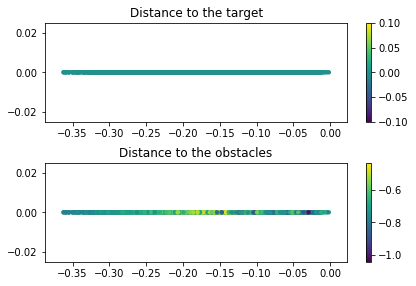

In [157]:
def collisionDistance(q):
     '''Return the minimal distance between robot and environment. '''
     pin.updateGeometryPlacements(robot.model,robot.data,robot.collision_model,robot.collision_data,q)
     if pin.computeCollisions(robot.collision_model,robot.collision_data,False): 0
     idx = pin.computeDistances(robot.collision_model,robot.collision_data)
     return robot.collision_data.distanceResults[idx].min_distance
    
def distance(q1, q2):
    return np.linalg.norm(q1-q2)

def sampleSpace(nbSamples=500):
     '''
     Sample nbSamples configurations and store them in two lists depending
     if the configuration is in free space (hfree) or in collision (hcol), along
     with the distance to the target and the distance to the obstacles.
     '''
     hcol = []
     hfree = []
     for i in range(nbSamples):
          q = random_gen(False)
          if not collision(robot, q):
               hfree.append( list(q.flat) + [ distance(q,q_goal), collisionDistance(q) ])
          else:
               hcol.append(  list(q.flat) + [ distance(q,q_goal), 1e-2 ])
     return hcol,hfree

def plotConfigurationSpace(hcol,hfree,markerSize=20):
     '''
     Plot 2 "scatter" plots: the first one plot the distance to the target for 
     each configuration, the second plots the distance to the obstacles (axis q1,q2, 
     distance in the color space).
     '''
     htotal = hcol + hfree
     h=np.array(htotal)
     plt.subplot(2,1,1)
     plt.scatter(h[:,0],h[:,1],c=h[:,2],s=markerSize,lw=0)
     plt.title("Distance to the target")
     plt.colorbar()
     plt.subplot(2,1,2)
     plt.scatter(h[:,0],h[:,1],c=h[:,3],s=markerSize,lw=0)
     plt.title("Distance to the obstacles")
     plt.colorbar()
     plt.tight_layout(pad=0.8)

hcol,hfree = sampleSpace(2000) #increase to improve resolution
plotConfigurationSpace(hcol,hfree)


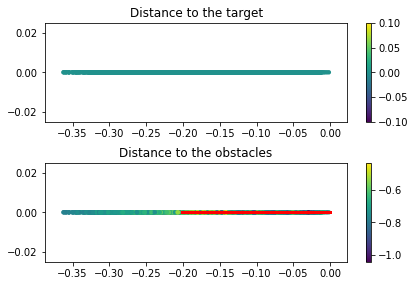

In [158]:
def plotpaths(paths, colors = ['r','c']):
    plotConfigurationSpace(hcol,hfree)
    for path, color in zip(paths,colors):
        patharray = np.array(path)
        plt.plot(patharray[:,0],patharray[:,1],color,lw=3)
    
plotpaths([getpath(G)])

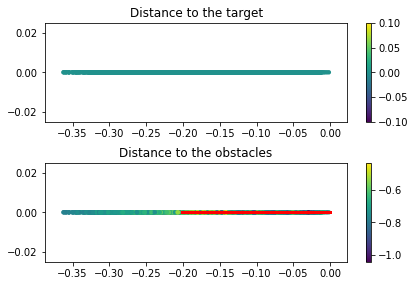

In [159]:
path = getpath(G)
def shortcut(path):
    for i, q in enumerate(path):
        for j in reversed(range(i+1,len(path))):
            q2 = path[j]
            q_new = NEW_CONF(q,q2,discretisationsteps_newconf, delta_q = delta_q)
            if VALID_EDGE(q,q2,discretisationsteps_validedge):
                path = path[:i+1]+path[j:]
                return path
    return path


colors = ["b","c","m","y"]
originalpath = path[:]
shortcutpath = originalpath[:]

for _ in range(10):
    shortcutpath = shortcut(shortcutpath)
        
plotpaths([shortcutpath])

# displaypath(robot, originalpath, 0.4, viz)
# displaypath(robot, shortcutpath, 0.4, viz)

# Part 1: Geometry <a class="anchor" id="part1"></a>
In this first part of the lab, we are concerned with the geometry of the robot and in motion planning in general.
We are going to compute a geometric path that will serve as a guide for the dynamic part. Concretely, your objective is to compute a collision free path for the robot such that it "grasps" the cube and carries it over to its target position. Again, no dynamic computations are required in this phase, we are only interested in configurations that should be collision free, respect joint limits and geometrically consistent in terms of placement; there is already some work to be done here!

## I. Computing the target configurations (Inverse Geometry) <a class="anchor" id="IG"></a>

Your first task is the following: write the functions that generate an initial and a goal configuration for the nextage robot, such that the ```LEFT_HAND``` and ```RIGHT_HAND```are aligned respectively with the ```LEFT_HOOK``` and ```RIGHT_HOOK``` frames when the cube is located at its starting position  (```CUBE_PLACEMENT```) and at its goal position (```CUBE_PLACEMENT_TARGET```)

For this implement the method ```computeqgrasppose``` in inverse_geometry.py 

The main method indicates how the method is going to be called to obtain the q0 and qe configurations:
```
q0 = computeqgrasppose(robot, q, cube, CUBE_PLACEMENT, viz)
qe = computeqgrasppose(robot, q, cube, CUBE_PLACEMENT_TARGET,  viz)
```

Of course, q0 and qe should be collision-free and respect the joint limits of the robot. Do not hard-code anything here. In my tests I will use different targets to test the generality of ```computeqgrasppose```.

q0 should look somehow like this:
<img src="./images/q0.png" alt="drawing" width="200"/>



**hints:** 
* If your configurations look unnatural, you probably want to somehow introduce a "postural bias" in whatever method you are using 
* From the obtained configurations, you can easily obtain the relative placement between both hands expressed in a specific frame. This might prove relevant later in the lab so you may want to store it somewhere (maybe in solution.py)


## II. Motion planning <a class="anchor" id="motion_planning"></a>

For section II, I am proposing one course of action to successfully achieve the planning of a motion such that the robot carries the cube from its initial configuration to the end configuration. You are free to choose another course of action, but I do not advise it unless you really know what you are doing. In any case talk to me before making that decision. No matter what approach you choose, the method ```computepath``` from path.py must be implemented as specified for you to get the points.

To compute a geometric path that represents a collision-free motion of our robot carrying the cube from q0 to qe, I suggest to use a sampling based motion planner. 

We will use the path.py file to write the motion planning algorithm

### II.a Sampling configurations
To generate configurations for the planner, I suggest a 2 step process: randomly sample configurations for the cube, then solve an inverse geometry problem to generate a valid pose on that location. Of course, check that the joint limits are respected and the configuration is collision-free before returning it.

**hint:** you are free to bound your problem by ensuring that the cube placements that you generate only occur at positions / orientations that you think are interesting.

### II.b Path projection
However to do this we need to enforce the constraint that every sampled configuration is such that the effectors are holding the cube.

Furthermore, the grasping constraint will apply to the complete path: a standard linear interpolation between two grasping configurations is not enough to guarantee that every interpolated configuration is such that the cube is grasped.
Write a function that, given two configurations q0 and q1 and a discretisation step, returns an interpolated path between q0 and q1 such that every configuration in the path corresponds to a grasping pose. If it is not possible to generate such path, it will return a flag indicating so and, depending on your own decision, either return the part of the path that is valid, or nothing

### II.c Solution path generation
With the methods produced in II.1 and II.2, you should now be able to implement a motion planner that generates a geometrically valid path between q0 and qe. You can probably reuse code from the motion planning tutorial here, or implement you own. 

**requirement:** For me to assess this part you are required to implement the method ```computepath``` according to its documentation

# Part 2: Dynamics <a class="anchor" id="part2"></a>
Now that you have computed a reference path for your robot, it is time to try controlling it in a dynamics simulator. We will use pybullet for this. In theory pybullet is already installed but if not you should install it with pip:





In [19]:
!pip install pybullet

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip



This second part consists in two tasks. First, converting your path into a time-parametrised trajectory, then tracking this trajectory using the control law of your choice.

Again, you are free to use any method that you want to both tasks. 


## Week 6 advice:
We have not yet covered everything needed to fully achieve the lab below, though next week we will cover everything that is missing. I would suggest working in the following way for week 6:

+ for 2.I, use the level 0 approach for now. We will cover trajectory optimisation in next week's lecture. If you are already familiar with this you can go for level 1 of course if you want to.

+ For 2.II, you already have everything needed to write a torque controller for moving without grasping the cube. You can thus get started on the task 0 described in 2.II You will need this step anyway to move on to the grasping.

## I. From a path to a trajectory <a class="anchor" id="TO"></a>
The first step is to parametrise your path into a time-varying trajectory that you may want to track.
Depending on your choice of a control law, this trajectory could be in the configuration space, the task space, or even something else.

I do not provide a template for this step, you are free to use any method that you see fit, so if you don't want to be bothered you can simply manually parametrise your trajectory (which is the level 0 described thereafter). However, you can score bonus marks if you go with more advanced methods. This will be described in the coming marking criteria. 


### 1. level 0: Manually set a velocity profile
Come up with a time parametrisation for your path that intuitively makes sense and move on to the control part! To do this write an interpolation function that given a certain $t$ will return a configuration in your path as well as the corresponding velocity and accelerations desired at that time. I advise to work out something that is such that the starting and final velocities are 0. 

### 2. level 1: QP programming without collision constraints (covered in next week's lecture)
What I would recommend is to use quadratic programming to solve a least square problem that fits at best the path that you computed while satisfying constraints.

The class Bezier defined in [bezier.py](https://github.com/ediaro23/lab/blob/main/bezier.py) might prove useful.
Take a look at the [primer on Bezier curves](https://pomax.github.io/bezierinfo/) if you want more info on these methods. An example of use is provided in [control.py](https://github.com/ediaro23/lab/blob/9a2b0c74b4ba1702da8f86fc1fa845e513ab4cfd/control.py#L47).

The motivations for using Bezier curves are multiple:

+ First, they are strictly equivalent to polynomials, which means that the trajectory you will compute will be continuous and infinitely differentiable.

+ Secondly, the initial and terminal conditions are easy to specify: the velocity at the start / end only depends on the first/last two control points, and the accelerations only on the the first/last three control points. If you choose your first three control points to be strictly equal for instance, the initial velocity and acceleration of your trajectory will be 0.

+ Thirdly, a Bezier curve lies completely in the convex hull of its control points. What this means for optimisation is that if you define linear inequality constraints on the control points of the curve, you have the guarantee that that every point on the curve satisfies these constraints. This will allow you to easily specify constraints on the derivatives

If you choose to go that way, you can decide that your optimisation variables are the control points of your Bezier curve; you can then linearly define the value of the trajectory at each time step as a linear combination of these control points and write your cost function as a function of these points.


In this approach, the idea is not to explicitely address the collision constraints. You will assume that if you track your path well enough you will avoid collisions. This is commonly done in robotics.

**Optional: the ndcurves library**

If you are interested in trajectory optimisation, you could check out [this tutorial I wrote for the ndcurves library](https://github.com/loco-3d/ndcurves/blob/master/python/test/sandbox/test.ipynb). While the API is different the concepts described are the same. **Note that I m not necessarily suggesting to use ndcurves, simply to look at the tutorials to understand the ideas and replicate this.** Still, if you want to you can decide to directly use ndcurves. It has an api a bit more complex that the simple Bezier class I provided as it is more powerful, so it is for you to decide, there is no good or bad solution here.



#### Time parametrisation:
If you follow the guidelines from the tutorial, the optimisation will give you a smooth trajectory, but by default it will have a duration of 1. You can easily add velocity constraints and include time as a variable in your problem . You could also add acceleration constraints and ignore velocities by using $t^2$ as a variable instead of $t$. We can discuss this on Piazza. You can't consider both velocity and acceleration constraints otherwise your problem will become non-linear (do you see why ?)

#### Handling grasping constraints:
If you are planning a trajectory just for the effectors then it is really easy to handle these constraints: you can just plan for the cube and then deduce the effector placements at each step.
It might be harder to do it for a configuration space trajectory, but it is not necessarily required:
I believe that if the tracked trajectory is good enough you should not need to handle the grasping constraints as accurately as this will be fixed by the control law. 
If you want to handle these constraints, there are a variety of post processes that you can choose to implement this, but though the problem becomes non-linear again... I suggest to avoid this unless it really proves useful (again I think not, or at least it was not necessary for me).



### 3. level 2: Handling collision constraints
First of all, don't go there in the first instance. Wait until you are done with the complete lab to decide whether you are interested in doing this. You can try to handle collisions in a variety of ways that we can discuss on Piazza. The straightforward approach is to write a non linear program that will handle this as we have done before. Because you have a reference motion that is collision free, you may get away with a NLP to refine the trajectory obtained when solving level 1 so as to avoid collisions.

## II. Implementing a torque control law <a class="anchor" id="control"></a>
Ok now, you have everything that you need to grasp that box and move it to its target.

Again, we are going to use pybullet to control our robot. Pybullet is a dynamics simulator which is used by roboticists to test the behaviours of their controllers before deploying them on their robots. It was originally developed for video games, and depending on your application it is not always considered as very accurate. However for manipulators it works well.

### Interaction with Pybullet 

The philosophy I propose to interact with Pybullet is implemented in the [control.py main function](https://github.com/ediaro23/lab/blob/9a2b0c74b4ba1702da8f86fc1fa845e513ab4cfd/control.py#L61):

+ Set the initial configuration of your robot in pybullet (method setqsim)

+ At each frame:

    - get the current state of the robot in the simulator (method getpybulletstate)
    
    - work out all the computations in pinocchio
    
    - send a torque command to the simulator to update the state of the robot (method step)

Pybullet is configured here to work as a step-by-step simulation, as opposed to real time. Everytime you call the step method, the simulation integrates DT seconds of time, with DT defined in config.py.

In tools.py, I have added a method [rununtil](https://github.com/ediaro23/lab/blob/9a2b0c74b4ba1702da8f86fc1fa845e513ab4cfd/tools.py#L102C5-L102C10) that you can use to update the simulation at a frequency that corresponds to a realtime mode.

If you run control.py, assuming the initial state is the robot.q0 configuration, the first thing you will see is a very chaotic behaviour from the robot: indeed, as it starts in collision, the simulator will apply really high forces to compense the penetration violation.

If you initialise correctly the inital state, in the absence of torque command the robot arms will fall under the effect of gravity.

The main methods needed to work with pybullet are defined in the Simulation class defined in [setup_pybullet.py](https://github.com/ediaro23/lab/blob/9a2b0c74b4ba1702da8f86fc1fa845e513ab4cfd/setup_pybullet.py). A few others are defined in the base class Simulation_base but I don't expect you will need them.

The helper method to load the robot in both pinocchio and pybullet environments is setupwithpybullet. If you still want to work with meshcast in parallel (for some strange reason that I can't explain I found it convenient) you can instead call setupwithpybulletandmeshcat.


### Optional task 0: Control without the cube
To test your controller, it might be a good idea to first control the motion of the effectors without grasping the cube. Generate a simple trajectory that brings the effectors above the starting position and implement the control law to achieve the motion. Regarding the gains, you definitely have the options to tune them individually for each joint (and you would have do this on the actual robot). When I programmed the lab I just used Kp = 300 and $Kd = 2 \sqrt(Kd)$ for all joints and it worked fine. Once you ll have verified that you obtain a satisfying behaviour, you'll be ready to move to the actual task.

### The actual task
Proceed as you wish to have the robot grasp the cube and then bring it to the target location. It does not matter to me how this is achieved in terms of the motion I see, as long as some grasping (ie the robot is holding the cube above the table for some relevant period of time) happens. You can push the cube to align it in the end if you need. 

To achieve the behaviour, you will need to apply a control law. Everything here is set for you to control the robot in torque, which I do believe is the easy way to go. If you want to try controling this using position or velocity control, this is also an option (actually the real Nextage robot is only position controlled).

The recommended way, in my opinion, is to apply inverse dynamics control to track the trajectory while applying a linear force to the cube with both hands.

This force control law should naturally cope with the alignment errors and have the effect of attracting the effectors to the cube 

